In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [136]:
import pyccl
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

from coefficient import *
from one_map import *
from sky_frac import *

In [126]:
from matplotlib import rcParams
rcParams['xtick.direction'] = 'in'
rcParams['xtick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.visible'] = True
rcParams['ytick.major.size'] = 10
rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 14

---

## $S_8$ vs. galaxy bias 

* how do i make this connection?

In [53]:
# galaxy biases for clustering maps
biases = [1.42, 1.65, 1.60, 1.92, 2.00]

b1_array = np.linspace(1.22,1.62,21)
thr_ct = 10
array_len = thr_ct*3
nside = 256
N = 12*nside*nside
smoothing = 20
itr = 100
b=10

In [60]:
def galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b):
    
    N = 12*nside*nside
    
    # fixed map iterations
    v_all_fixed = np.zeros((itr,array_len))
    for i in range(itr):
        c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all_fixed[i] = np.concatenate((v0,v1,v2))
        
    # fixed map mean    
    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
            v_all_mean[i] = np.mean(v_all_fixed[:,i])
            
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    # applying 10 S_8 values
    v_all = np.zeros((b,array_len))
    for i in range(b):
        c_map, l_map = simulate_des_maps_bias(omega_m[i], sigma_8[i], smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all[i] = np.concatenate((v0,v1,v2))  

    # covariance
    cov = np.cov((v_all_fixed.transpose()))
    
    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_all[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d
            
    return L

In [110]:
L = np.zeros((len(b1_array),b))

for i,b1 in enumerate(b1_array):
    L[i] = galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b)
    print(i)
    
print(L.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
(21, 10)


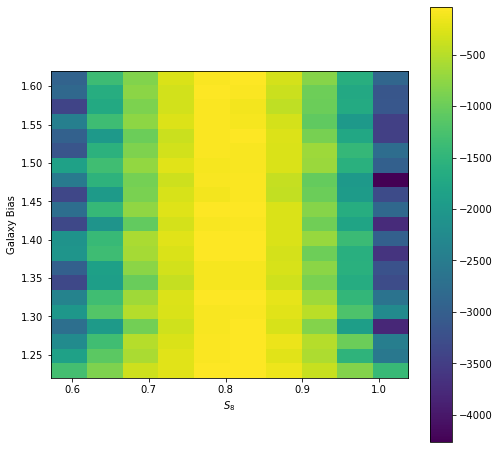

In [52]:
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
a = ax1.imshow(L, origin='lower', extent=[min(S_8),max(S_8),min(b1_array),max(b1_array)])
a
ax1.set_aspect(2)
#ax1.set_title('Likelihood Plot')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a);
plt.savefig('s8_gb_L')

In [48]:
L = np.loadtxt('S8_GB_likelihood.out')

In [82]:
# wider galaxy bias range
'''
b1_array = np.linspace(0.92,1.82,10)
L = np.zeros((len(b1_array),thr_ct))
for i,b1 in enumerate(b1_array):
    L[i] = galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b)
    print(i)
'''

'\nb1_array = np.linspace(0.92,1.82,10)\nL = np.zeros((len(b1_array),thr_ct))\nfor i,b1 in enumerate(b1_array):\n    L[i] = galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b)\n    print(i)\n'

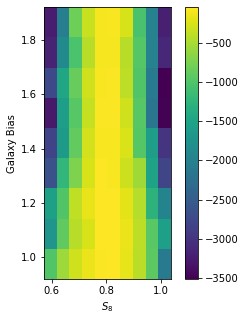

In [76]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
a = ax1.imshow(L_wide, origin='lower', extent=[min(S_8),max(S_8),min(b1_array),max(b1_array)])
a
ax1.set_aspect(2)
#ax1.set_title('Likelihood Plot')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a);
plt.savefig('s8_gb_L')

In [196]:
# test sigma_8 vs bias

def galaxy_bias2(b1,itr,thr_ct,nside,smoothing,array_len,b):
    
    N = 12*nside*nside
    
    # fixed map iterations
    v_all_fixed = np.zeros((itr,array_len))
    for i in range(itr):
        c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all_fixed[i] = np.concatenate((v0,v1,v2))
        
    # fixed map mean    
    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
            v_all_mean[i] = np.mean(v_all_fixed[:,i])
            
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    # applying 10 S_8 values
    v_all = np.zeros((b,array_len))
    for i in range(b):
        c_map, l_map = simulate_des_maps_bias(0.3, sigma_8[i], smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all[i] = np.concatenate((v0,v1,v2))  

    # covariance
    cov = np.cov((v_all_fixed.transpose()))
    
    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_all[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d
            
    return L

In [202]:
# NISHA RUN THIS TONIGHT

b1_array2 = np.linspace(1.22,1.62,5)

L2 = np.zeros((len(b1_array2),b))

for i,b1 in enumerate(b1_array2):
    L2[i] = galaxy_bias2(b1,itr,thr_ct,nside,smoothing,array_len,b)
    print(i)
    
print(L2.shape)

0
1
2
3
4
(5, 10)


In [201]:
np.linspace(1.22,1.62,5)

array([1.22, 1.32, 1.42, 1.52, 1.62])

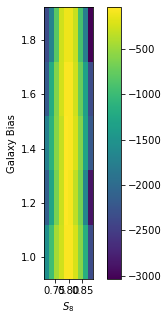

In [210]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
a = ax1.imshow(L2, origin='lower', extent=[min(sigma_8),max(sigma_8),min(b1_array),max(b1_array)])
a
ax1.set_aspect(2)
#ax1.set_title('Likelihood Plot')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a);
plt.savefig('s8_gb_L')

#### Plot MFs with varying galaxy biases around 1.42

In [122]:
bias_array = np.linspace(1.22,1.62,5)
thr_ct = 10
N = 12*nside*nside

v_b = np.zeros((len(bias_array),10))
v0_b = np.zeros((len(bias_array),10))
v1_b = np.zeros((len(bias_array),10))
v2_b = np.zeros((len(bias_array),10))

for i,b1 in enumerate(bias_array):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, 20, 256, b1, nmax=1)
    v_b[i],v0_b[i],v1_b[i],v2_b[i] = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
    print(i)

0
1
2
3
4


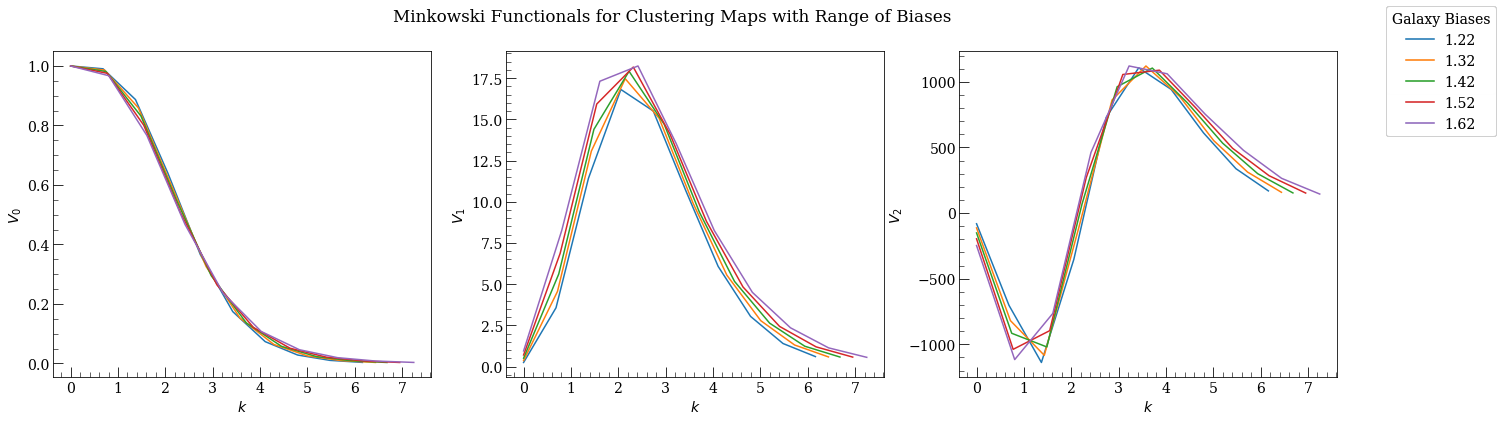

In [243]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Biases \n'))
for i in range(len(bias_array)):
    ax1.plot(v_b[i],v0_b[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_b[i],v1_b[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_b[i],v2_b[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(np.linspace(1.22,1.62,5),title = 'Galaxy Biases') 

#### smoothing

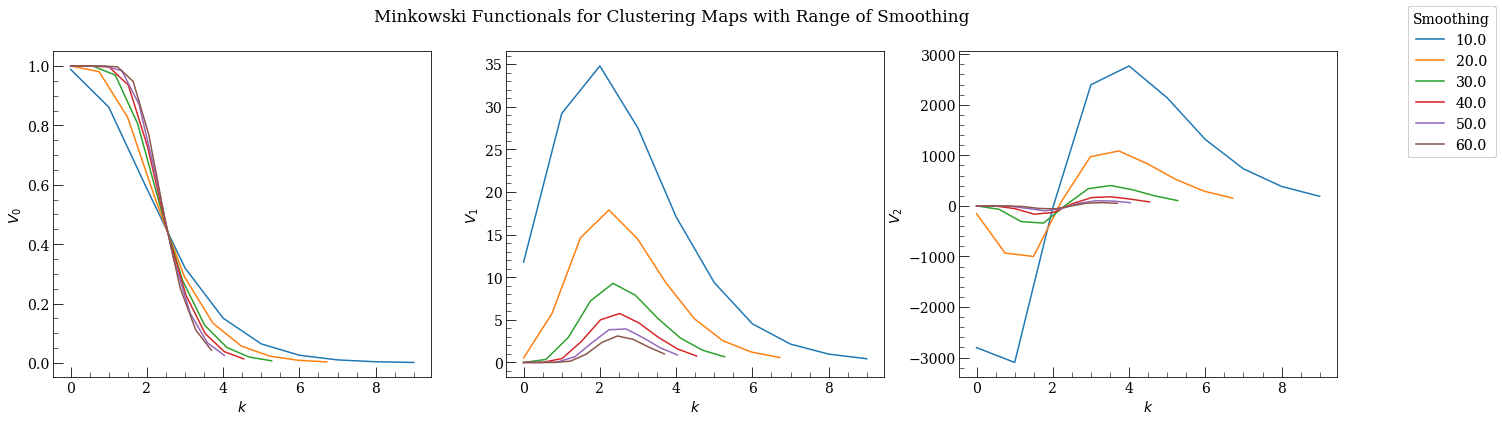

In [198]:
# clustering 
s_array = np.linspace(10,60,6,dtype=int)
thr_ct = 10
nside = 256
N = 12*nside*nside

v_s = np.zeros((len(s_array),10))
v0_s = np.zeros((len(s_array),10))
v1_s = np.zeros((len(s_array),10))
v2_s = np.zeros((len(s_array),10))

for i,s in enumerate(s_array):
    c_map, l_map = simulate_des_maps(0.3, 0.8, s, 256, nmax=1)
    v_s[i],v0_s[i],v1_s[i],v2_s[i] = calc_mf(c_map[0], thr_ct, N, is_clustering=True)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Smoothing \n'))
for i in range(len(s_array)):
    ax1.plot(v_s[i],v0_s[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_s[i],v1_s[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_s[i],v2_s[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(np.linspace(10,60,6,dtype=int),title = 'Smoothing');

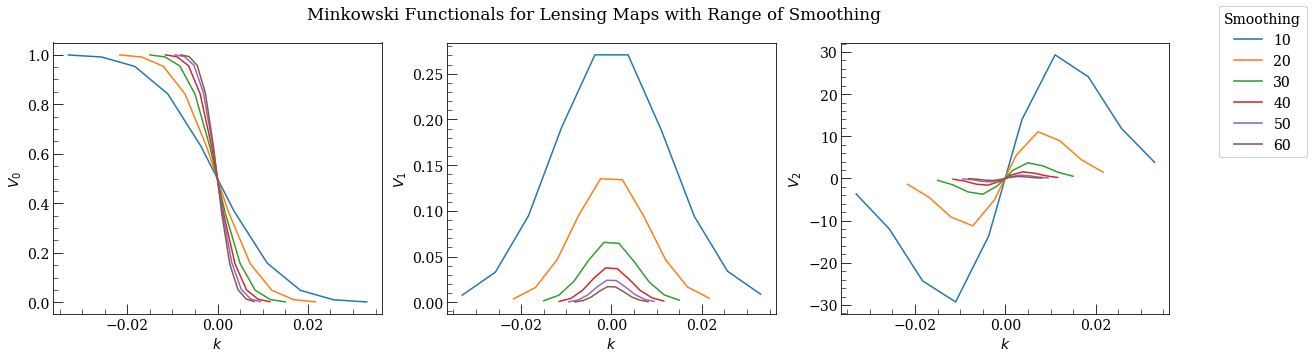

In [208]:
# smoothing lensing
s_array = np.linspace(10,60,6,dtype=int)
thr_ct = 10
nside = 256
N = 12*nside*nside

v_s = np.zeros((len(s_array),10))
v0_s = np.zeros((len(s_array),10))
v1_s = np.zeros((len(s_array),10))
v2_s = np.zeros((len(s_array),10))

for i,s in enumerate(s_array):
    c_map, l_map = simulate_des_maps(0.3, 0.8, s, 256, nmax=1)
    v_s[i],v0_s[i],v1_s[i],v2_s[i] = calc_mf(l_map[0], thr_ct, N, is_clustering=False)
    
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Lensing Maps with Range of Smoothing'))
for i in range(len(s_array)):
    ax1.plot(v_s[i],v0_s[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_s[i],v1_s[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_s[i],v2_s[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(np.linspace(10,60,6,dtype=int),title = 'Smoothing') 
    


#### nside

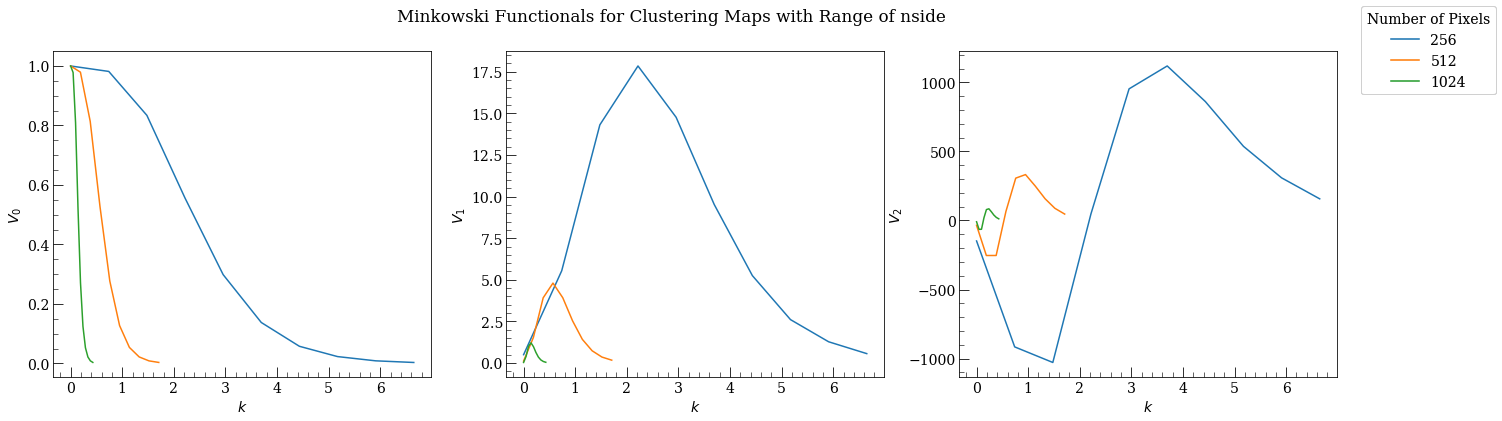

In [133]:
# clustering
n_array = [256,512,1024]
thr_ct = 10
smoothing = 20

v_n = np.zeros((len(n_array),10))
v0_n = np.zeros((len(n_array),10))
v1_n = np.zeros((len(n_array),10))
v2_n = np.zeros((len(n_array),10))

for i,n in enumerate(n_array):
    c_map, l_map = simulate_des_maps(0.3, 0.8, smoothing, n, nmax=1)
    N = 12*n*n
    v_n[i],v0_n[i],v1_n[i],v2_n[i] = calc_mf(c_map[0], thr_ct, N, is_clustering=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of nside \n'))
for i in range(len(n_array)):
    ax1.plot(v_n[i],v0_n[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_n[i],v1_n[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_n[i],v2_n[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(n_array,title = 'Number of Pixels') 

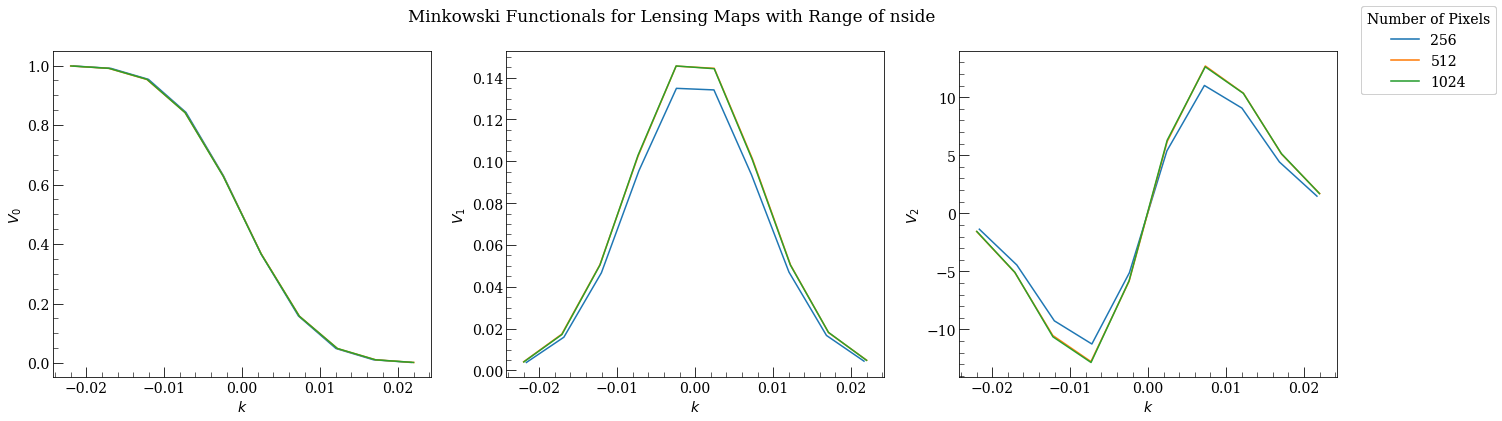

In [205]:
# lensing
n_array = [256,512,1024]
thr_ct = 10
smoothing = 20

v_n = np.zeros((len(n_array),10))
v0_n = np.zeros((len(n_array),10))
v1_n = np.zeros((len(n_array),10))
v2_n = np.zeros((len(n_array),10))

for i,n in enumerate(n_array):
    c_map, l_map = simulate_des_maps(0.3, 0.8, smoothing, n, nmax=1)
    N = 12*n*n
    v_n[i],v0_n[i],v1_n[i],v2_n[i] = calc_mf(l_map[0], thr_ct, N, is_clustering=False)
    
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Lensing Maps with Range of nside \n'))
for i in range(len(n_array)):
    ax1.plot(v_n[i],v0_n[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_n[i],v1_n[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_n[i],v2_n[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(n_array,title = 'Number of Pixels') 

#### threshold

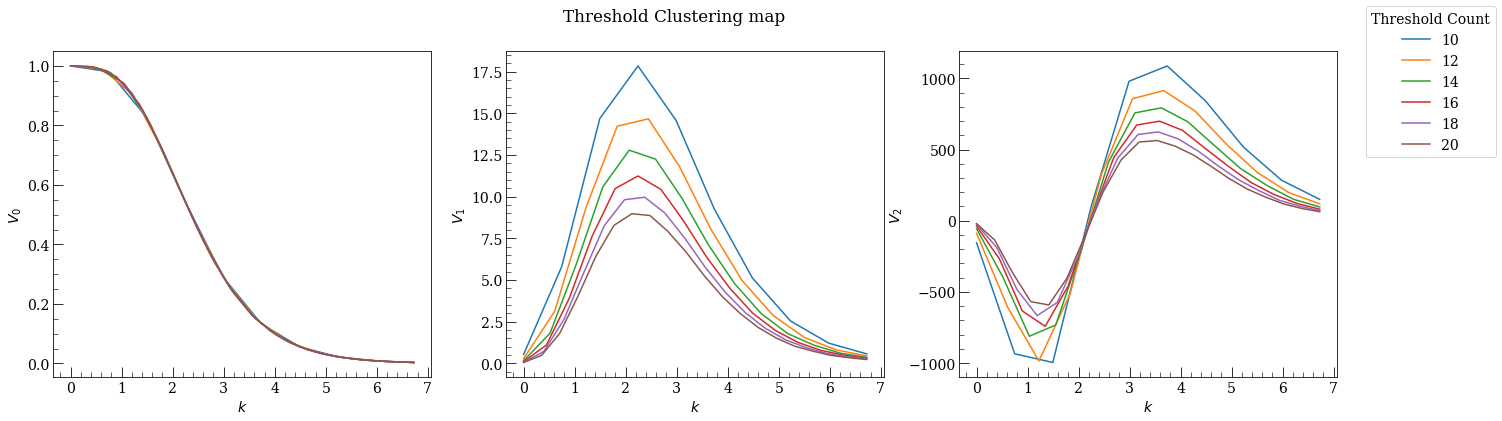

In [200]:
# clustering
t_array = np.linspace(10,20,6,dtype=int)
thr_ct = 10
smoothing = 20
nside = 256
N = 12*nside*nside

# 10
v_t_10 = np.zeros(10)
v0_t_10 = np.zeros(10)
v1_t_10 = np.zeros(10)
v2_t_10 = np.zeros(10)

# 12
v_t_12 = np.zeros(12)
v0_t_12 = np.zeros(12)
v1_t_12 = np.zeros(12)
v2_t_12 = np.zeros(12)

#14
v_t_14 = np.zeros(14)
v0_t_14 = np.zeros(14)
v1_t_14 = np.zeros(14)
v2_t_14 = np.zeros(14)

#16
v_t_16 = np.zeros(16)
v0_t_16 = np.zeros(16)
v1_t_16 = np.zeros(16)
v2_t_16 = np.zeros(16)

#18
v_t_18 = np.zeros(18)
v0_t_18 = np.zeros(18)
v1_t_18 = np.zeros(18)
v2_t_18 = np.zeros(18)

#20
v_t_20 = np.zeros(20)
v0_t_20 = np.zeros(20)
v1_t_20 = np.zeros(20)
v2_t_20 = np.zeros(20)

# build simulation
c_map, l_map = simulate_des_maps(0.3, 0.8, smoothing, nside, nmax=1)

# calc mfs for different threshold values
v_t_10,v0_t_10,v1_t_10,v2_t_10 = calc_mf(c_map[0], 10, N, is_clustering=True)
v_t_12,v0_t_12,v1_t_12,v2_t_12 = calc_mf(c_map[0], 12, N, is_clustering=True)
v_t_14,v0_t_14,v1_t_14,v2_t_14 = calc_mf(c_map[0], 14, N, is_clustering=True)
v_t_16,v0_t_16,v1_t_16,v2_t_16 = calc_mf(c_map[0], 16, N, is_clustering=True)
v_t_18,v0_t_18,v1_t_18,v2_t_18 = calc_mf(c_map[0], 18, N, is_clustering=True)
v_t_20,v0_t_20,v1_t_20,v2_t_20 = calc_mf(c_map[0], 20, N, is_clustering=True)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
#fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Threshold \n'))

ax1.plot(v_t_10,v0_t_10,label='10')
ax1.plot(v_t_12,v0_t_12,label='12')
ax1.plot(v_t_14,v0_t_14,label='14')
ax1.plot(v_t_16,v0_t_16,label='16')
ax1.plot(v_t_18,v0_t_18,label='18')
ax1.plot(v_t_20,v0_t_20,label='20')
ax1.set_xlabel('$k$')
ax1.set_ylabel('$V_0$')

ax2.plot(v_t_10,v1_t_10,label='10')
ax2.plot(v_t_12,v1_t_12,label='12')
ax2.plot(v_t_14,v1_t_14,label='14')
ax2.plot(v_t_16,v1_t_16,label='16')
ax2.plot(v_t_18,v1_t_18,label='18')
ax2.plot(v_t_20,v1_t_20,label='20')
ax2.set_xlabel('$k$')
ax2.set_ylabel('$V_1$')

ax3.plot(v_t_10,v2_t_10,label='10')
ax3.plot(v_t_12,v2_t_12,label='12')
ax3.plot(v_t_14,v2_t_14,label='14')
ax3.plot(v_t_16,v2_t_16,label='16')
ax3.plot(v_t_18,v2_t_18,label='18')
ax3.plot(v_t_20,v2_t_20,label='20')
ax3.set_xlabel('$k$')
ax3.set_ylabel('$V_2$')

fig.legend(t_array,title = 'Threshold Count')
fig.suptitle('Threshold Clustering map'); 

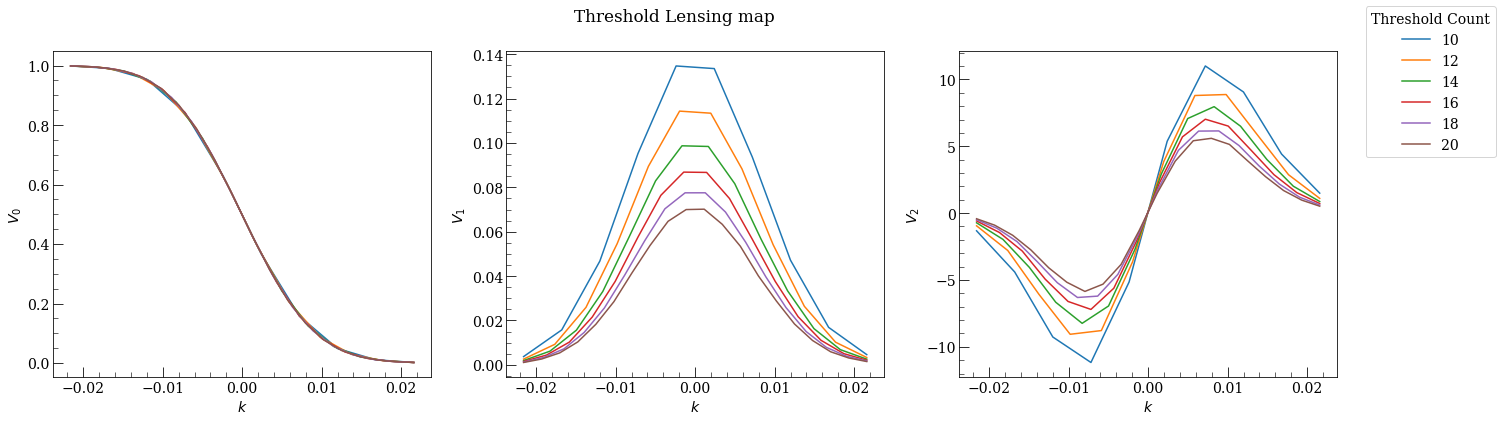

In [206]:
# lensing
t_array = np.linspace(10,20,6,dtype=int)
thr_ct = 10
smoothing = 20
nside = 256
N = 12*nside*nside

# 10
v_t_10 = np.zeros(10)
v0_t_10 = np.zeros(10)
v1_t_10 = np.zeros(10)
v2_t_10 = np.zeros(10)

# 12
v_t_12 = np.zeros(12)
v0_t_12 = np.zeros(12)
v1_t_12 = np.zeros(12)
v2_t_12 = np.zeros(12)

#14
v_t_14 = np.zeros(14)
v0_t_14 = np.zeros(14)
v1_t_14 = np.zeros(14)
v2_t_14 = np.zeros(14)

#16
v_t_16 = np.zeros(16)
v0_t_16 = np.zeros(16)
v1_t_16 = np.zeros(16)
v2_t_16 = np.zeros(16)

#18
v_t_18 = np.zeros(18)
v0_t_18 = np.zeros(18)
v1_t_18 = np.zeros(18)
v2_t_18 = np.zeros(18)

#20
v_t_20 = np.zeros(20)
v0_t_20 = np.zeros(20)
v1_t_20 = np.zeros(20)
v2_t_20 = np.zeros(20)

# build simulation
c_map, l_map = simulate_des_maps(0.3, 0.8, smoothing, nside, nmax=1)

# calc mfs for different threshold values
v_t_10,v0_t_10,v1_t_10,v2_t_10 = calc_mf(l_map[0], 10, N, is_clustering=False)
v_t_12,v0_t_12,v1_t_12,v2_t_12 = calc_mf(l_map[0], 12, N, is_clustering=False)
v_t_14,v0_t_14,v1_t_14,v2_t_14 = calc_mf(l_map[0], 14, N, is_clustering=False)
v_t_16,v0_t_16,v1_t_16,v2_t_16 = calc_mf(l_map[0], 16, N, is_clustering=False)
v_t_18,v0_t_18,v1_t_18,v2_t_18 = calc_mf(l_map[0], 18, N, is_clustering=False)
v_t_20,v0_t_20,v1_t_20,v2_t_20 = calc_mf(l_map[0], 20, N, is_clustering=False)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Lensing Maps with Range of Threshold \n'))

ax1.plot(v_t_10,v0_t_10,label='10')
ax1.plot(v_t_12,v0_t_12,label='12')
ax1.plot(v_t_14,v0_t_14,label='14')
ax1.plot(v_t_16,v0_t_16,label='16')
ax1.plot(v_t_18,v0_t_18,label='18')
ax1.plot(v_t_20,v0_t_20,label='20')
ax1.set_xlabel('$k$')
ax1.set_ylabel('$V_0$')

ax2.plot(v_t_10,v1_t_10,label='10')
ax2.plot(v_t_12,v1_t_12,label='12')
ax2.plot(v_t_14,v1_t_14,label='14')
ax2.plot(v_t_16,v1_t_16,label='16')
ax2.plot(v_t_18,v1_t_18,label='18')
ax2.plot(v_t_20,v1_t_20,label='20')
ax2.set_xlabel('$k$')
ax2.set_ylabel('$V_1$')

ax3.plot(v_t_10,v2_t_10,label='10')
ax3.plot(v_t_12,v2_t_12,label='12')
ax3.plot(v_t_14,v2_t_14,label='14')
ax3.plot(v_t_16,v2_t_16,label='16')
ax3.plot(v_t_18,v2_t_18,label='18')
ax3.plot(v_t_20,v2_t_20,label='20')
ax3.set_xlabel('$k$')
ax3.set_ylabel('$V_2$')

fig.legend(t_array,title = 'Threshold Count')
fig.suptitle('Threshold Lensing map'); 

#### Sky Fraction

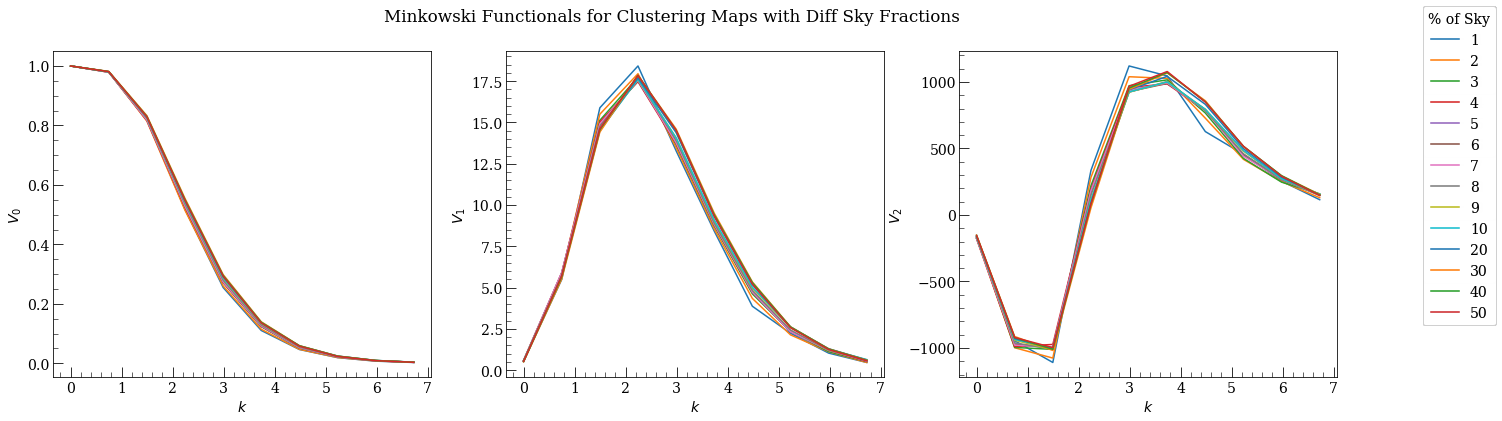

In [201]:
# clustering
N_p = 12*nside*nside

f_array = [int(floor(0.01*N_p)),int(floor(0.02*N_p)),int(floor(0.03*N_p)),int(floor(0.04*N_p)),int(floor(0.05*N_p)),
          int(floor(0.06*N_p)),int(floor(0.07*N_p)),int(floor(0.08*N_p)),int(floor(0.09*N_p)),int(floor(0.1*N_p)),
           int(floor(0.2*N_p)),int(floor(0.3*N_p)),int(floor(0.4*N_p)),int(floor(0.5*N_p))]


v_f = np.zeros((len(f_array),10))
v0_f = np.zeros((len(f_array),10))
v1_f = np.zeros((len(f_array),10))
v2_f = np.zeros((len(f_array),10))

for i,f in enumerate(f_array):
    v_f[i],v0_f[i],v1_f[i],v2_f[i] = calc_mf_f(c_map[0], thr_ct, int(f), is_clustering=True)

    
f_array_plot = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]#np.round((np.array(f_array,dtype=int)/N_p)*100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Diff Sky Fractions \n'))
for i in range(len(f_array)):
    ax1.plot(v_f[i],v0_f[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_f[i],v1_f[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_f[i],v2_f[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(f_array_plot,title = '% of Sky') 

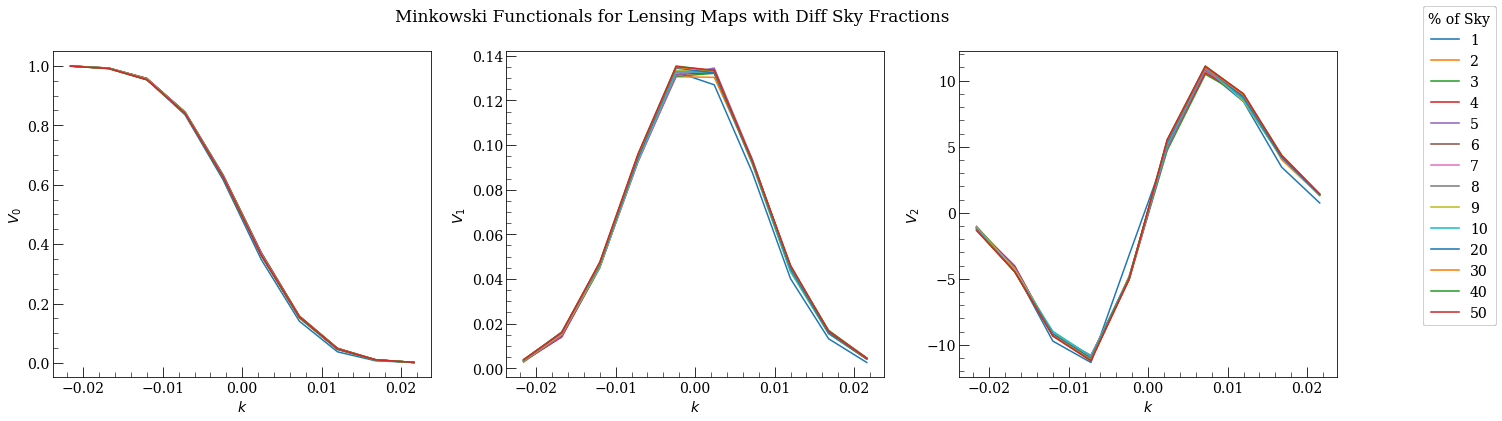

In [207]:
# lensing
N_p = 12*nside*nside

f_array = [int(floor(0.01*N_p)),int(floor(0.02*N_p)),int(floor(0.03*N_p)),int(floor(0.04*N_p)),int(floor(0.05*N_p)),
          int(floor(0.06*N_p)),int(floor(0.07*N_p)),int(floor(0.08*N_p)),int(floor(0.09*N_p)),int(floor(0.1*N_p)),
           int(floor(0.2*N_p)),int(floor(0.3*N_p)),int(floor(0.4*N_p)),int(floor(0.5*N_p))]


v_f = np.zeros((len(f_array),10))
v0_f = np.zeros((len(f_array),10))
v1_f = np.zeros((len(f_array),10))
v2_f = np.zeros((len(f_array),10))

for i,f in enumerate(f_array):
    v_f[i],v0_f[i],v1_f[i],v2_f[i] = calc_mf_f(l_map[0], thr_ct, int(f), is_clustering=False)

    
f_array_plot = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]#np.round((np.array(f_array,dtype=int)/N_p)*100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,6))
fig.suptitle(('Minkowski Functionals for Lensing Maps with Diff Sky Fractions \n'))
for i in range(len(f_array)):
    ax1.plot(v_f[i],v0_f[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_f[i],v1_f[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_f[i],v2_f[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(f_array_plot,title = '% of Sky') 

### Individual Steps

In [23]:
v_all_fixed = np.zeros((itr,array_len))
for i in range(itr):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
    v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
    v_all_fixed[i] = np.concatenate((v0,v1,v2))
    print(i)

In [28]:
v_all_mean = np.zeros(array_len)
for i in range(array_len):
    v_all_mean[i] = np.mean(v_all_fixed[:,i])

In [29]:
# calculate S_8

omega_m = np.linspace(0.2,0.4,b)
sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    
# calculate S_8
S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 

In [30]:
# applying 10 S_8 values

v_all = np.zeros((b,array_len))
for i in range(b):
    c_map, l_map = simulate_des_maps_bias(omega_m[i], sigma_8[i], smoothing, nside, b1, nmax=1)
    v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
    v_all[i] = np.concatenate((v0,v1,v2))

In [31]:
cov = np.cov((v_all_fixed.transpose()))

In [33]:
# singular covariance matrix workaround
good = cov.diagonal() > 0
cov2 = cov[good][:, good]

# calculate the likelihood          
L = np.zeros(b)
N_ = itr-1           # number of realisations - 1
p = array_len        # number of data points
    
try:
    inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
    for i in range(b):
        L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
except:
    inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
    for i in range(b):
        d = (v_all[i] - v_all_mean)[good]
        L[i] = -0.5 * d @ inv_cov2 @ d

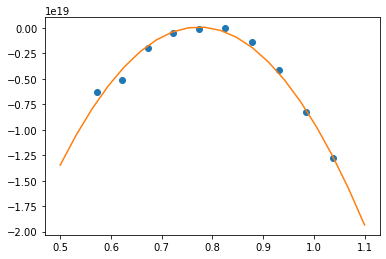

In [35]:
coefficient = np.polyfit(S_8,L,2)
poly = np.poly1d(coefficient)     
new_x = np.linspace(0.5,1.1,20)
new_y = poly(new_x)
plt.plot(S_8, L, "o", new_x, new_y);

In [ ]:
# calculate likelihood (S_8,b_1) 
# first for clustering map

### Multiplying Maps by 10 to investigate why galaxy bias is independent of S_8 

In [ ]:
def galaxy_bias2(b1,itr,thr_ct,nside,smoothing,array_len,b):
    
    N = 12*nside*nside
    
    # fixed map iterations
    v_all_fixed = np.zeros((itr,array_len))
    for i in range(itr):
        c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
        cmap = c_map[0]*10
        v,v0,v1,v2 = calc_mf(cmap, thr_ct, N, is_clustering=True)
        v_all_fixed[i] = np.concatenate((v0,v1,v2))
        
    # fixed map mean    
    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
            v_all_mean[i] = np.mean(v_all_fixed[:,i])
            
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    # applying 10 S_8 values
    v_all = np.zeros((b,array_len))
    for i in range(b):
        c_map, l_map = simulate_des_maps_bias(omega_m[i], sigma_8[i], smoothing, nside, b1, nmax=1)
        cmap = c_map[0]*10
        v,v0,v1,v2 = calc_mf(cmap, thr_ct, N, is_clustering=True)
        v_all[i] = np.concatenate((v0,v1,v2))  

    # covariance
    cov = np.cov((v_all_fixed.transpose()))
    
    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_all[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d
            
    return L

b1_array = np.linspace(1.22,1.62,5)
L = np.zeros((len(b1_array),b))

for i,b1 in enumerate(b1_array):
    L[i] = galaxy_bias2(b1,itr=100,thr_ct=10,nside=256,smoothing=20,array_len=30,b=10)
    
print(L.shape)

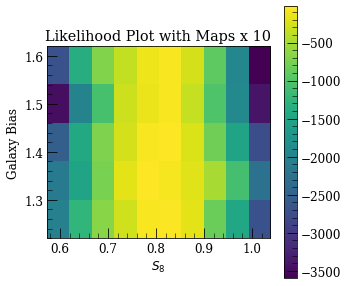

In [120]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
a_ = ax1.imshow(L, origin='lower', extent=[min(S_8),max(S_8),min(b1_array),max(b1_array)])
a_
ax1.set_aspect(2)
ax1.set_title('Likelihood Plot with Maps x 10')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a_);
#plt.savefig('s8_gb_L')

In [222]:
bias_array = np.linspace(1.22,1.62,5)
thr_ct = 10
N = 12*nside*nside

v_b_10 = np.zeros((len(bias_array),10))
v0_b_10 = np.zeros((len(bias_array),10))
v1_b_10 = np.zeros((len(bias_array),10))
v2_b_10 = np.zeros((len(bias_array),10))

for i,b1 in enumerate(bias_array):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, 20, 256, b1, nmax=1)
    cmap = 10*c_map[0]
    v_b_10[i],v0_b_10[i],v1_b_10[i],v2_b_10[i] = calc_mf(cmap, thr_ct, N, is_clustering=True)
    print(i)

0
1
2
3
4


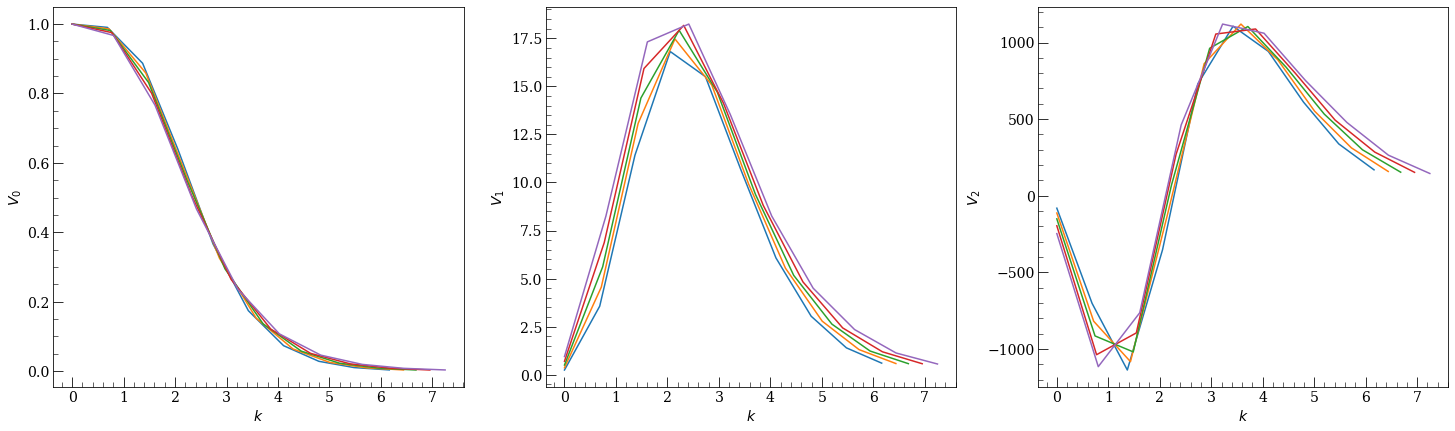

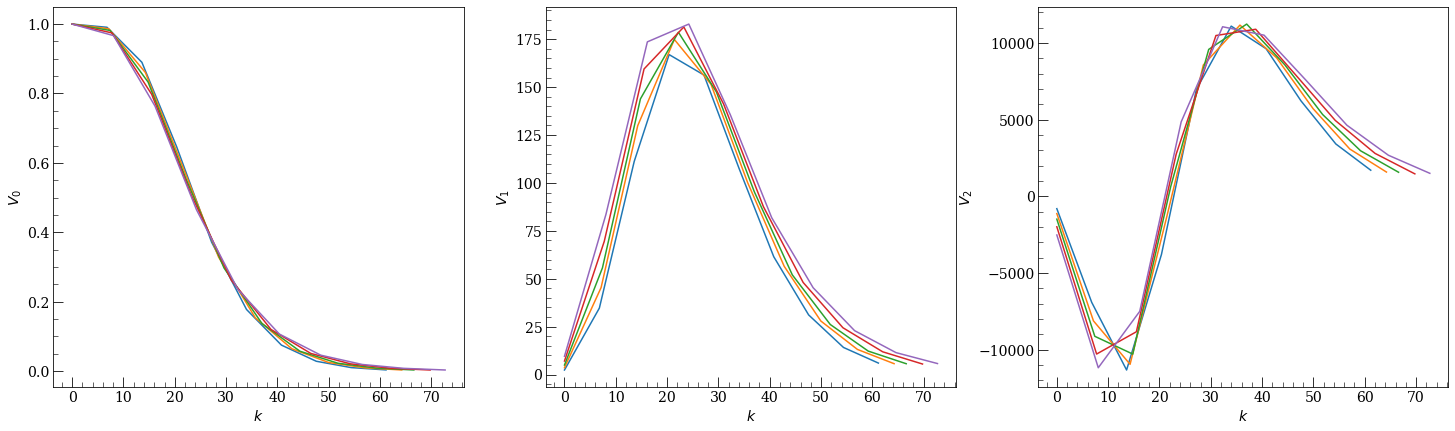

In [335]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,7))
#fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Biases \n'))
for i in range(len(bias_array)):
    ax1.plot(v_b[i],v0_b[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_b[i],v1_b[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_b[i],v2_b[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    #fig.legend(np.linspace(1.22,1.62,5),title = 'Galaxy Biases') 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,7))
#fig.suptitle(('Minkowski Functionals for Clustering Maps x 10 with Range of Biases \n'))
for i in range(len(bias_array)):
    ax1.plot(v_b_10[i],v0_b_10[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_b_10[i],v1_b_10[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_b_10[i],v2_b_10[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    #fig.legend(b1_array,title = 'Galaxy Biases') 

In [209]:
# plot MFs and compare to regular MF
# if same, MFs are insenstiive to scale (bc were dividing by sigma) increase mpas -> increase std
# should we normalize maps at all? future considerations

array([1.22, 1.32, 1.42, 1.52, 1.62])

---

## Predicting MFs using an interpolator to save time

* should all threshold values, 30 total
* do clustering and lensing maps separately

In [246]:
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

# make a grid of omega sigma points
a=4
omega,sigma = np.mgrid[0.2:0.4:a*1j,0.7:0.9:a*1j]

smoothing = 5
nside = 256

#### clustering map

In [247]:
# calculate MFs for the grid -> put output in a new grid
#V_clust = np.zeros((a,a,thr_ct*3))
itr=2
V_clust = np.zeros((itr,a,a,thr_ct*3))
os_grid = np.vstack((omega[:,0],sigma[0]))

for i in range(itr):
    for j,o in enumerate(omega[:,0]):
        for k,s in enumerate(sigma[0]):
            c_map, l_map = simulate_des_maps(o, s, smoothing, nside, nmax=1)
            v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
            V_clust[i][j][k] = np.concatenate((v0,v1,v2))

In [291]:
v_clust_mean = np.zeros((a,a,thr_ct*3))

for i in range(a):
    for j in range(a):
        for k in range(thr_ct*3):
            v_clust_mean[i][j][k] = mean(V_clust[:,i,j,k])
            
v_clust_mean.shape

(4, 4, 30)

In [289]:
# build interpolator
rgi = RegularGridInterpolator(os_grid, v_clust_mean, method='linear', bounds_error=True, fill_value=nan)

(4, 4, 30)


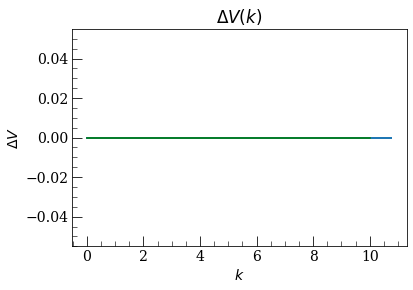

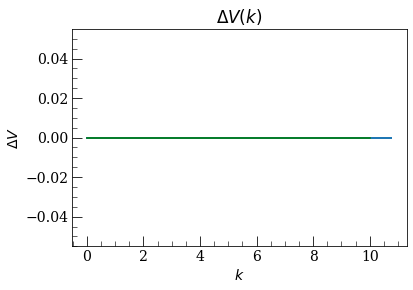

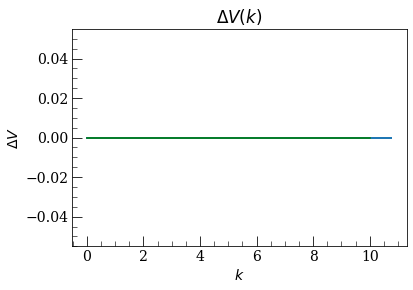

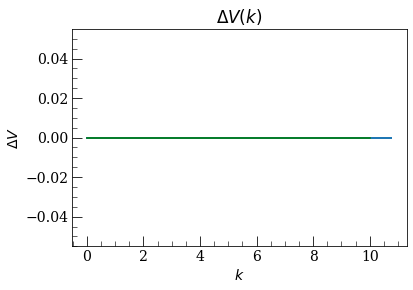

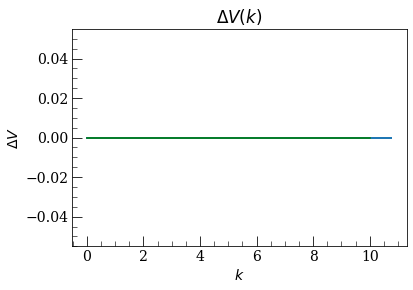

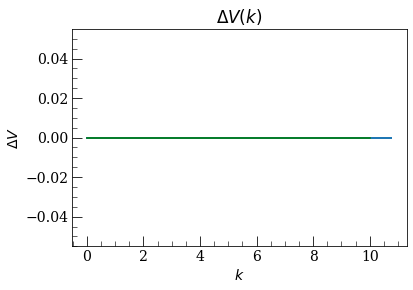

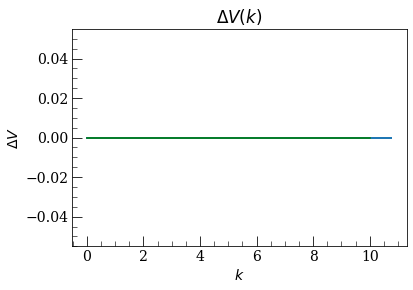

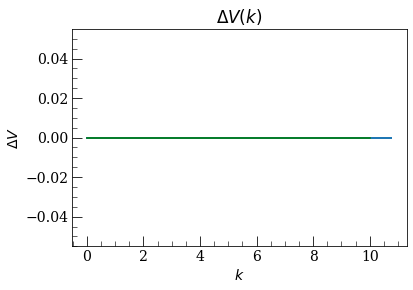

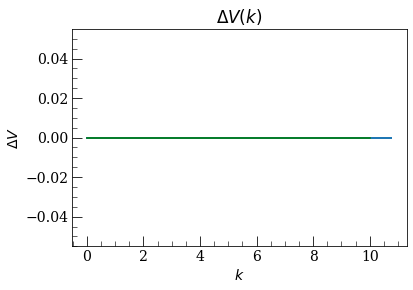

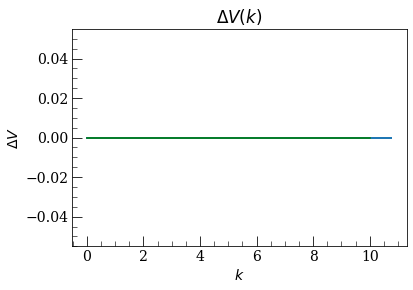

<Figure size 432x288 with 0 Axes>

In [290]:
# test model on data used to build model
V_test = np.zeros((a,a,thr_ct*3))
for i,o in enumerate(omega[:,0]):
    for j,s in enumerate(sigma[0]):
        V_test[i][j] = rgi((o,s))
        
print(V_test.shape)

x = np.linspace(0,thr_ct,thr_ct)
y = np.zeros(len(x))
V = np.concatenate((v,v,v))

#delta_V = (V_clust - V_test)/np.std(V_clust,axis=0)
delta_V = (v_clust_mean - V_test)/np.std(v_clust_mean,axis=0)
delta_V_plot = delta_V.reshape(a*a,thr_ct*3)

for t in range(thr_ct):
    plt.title((f'$\Delta V(k)$'))
    plt.plot(V,delta_V_plot[:][t])
    plt.plot(x,y,color='green')
    plt.xlabel('$k$')
    plt.ylabel('$\Delta V$')
    plt.figure();

### testing model on in between points

In [ ]:
'''# make a grid of points in between two input points

test = np.copy(os_grid)
for i in range(2):
    for j in range(a):
        if j<(a-1):
            test[i][j] = test[i][j] + np.random.random(1)*.001
        else:
            test[i][j] = test[i][j] - np.random.random(1)*.001
print(test)
'''

In [309]:
c = 6

test_points = np.vstack((np.linspace(os_grid[0][0],os_grid[0][1],6),np.linspace(os_grid[1][0],os_grid[1][1],c)))
test_points

array([[0.2       , 0.21333333, 0.22666667, 0.24      , 0.25333333,
        0.26666667],
       [0.7       , 0.71333333, 0.72666667, 0.74      , 0.75333333,
        0.76666667]])

In [340]:
'''# apply model to test points
V_test1 = np.zeros((c,thr_ct*3))
for i in range(c):
        V_test1[i] = rgi(test_points[:,i])

V_test1.shape
'''

(6, 30)

In [343]:
# find true values for test points

V_true = np.zeros((c,c,thr_ct*3))

for i,o in enumerate(test_points[0]):
    for j,s in enumerate(test_points[1]):
        c_map, l_map = simulate_des_maps(o, s, smoothing, nside, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        V_true[i][j] = np.concatenate((v0,v1,v2))

V_true.shape

(6, 6, 30)

(6, 6, 30)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

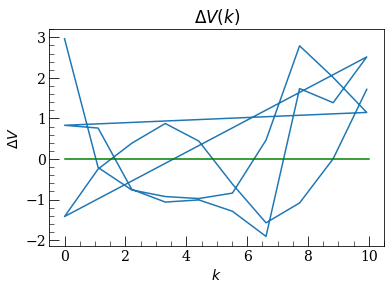

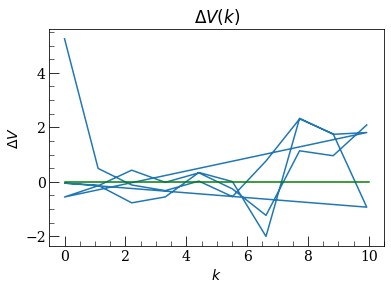

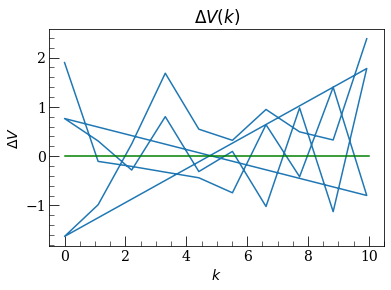

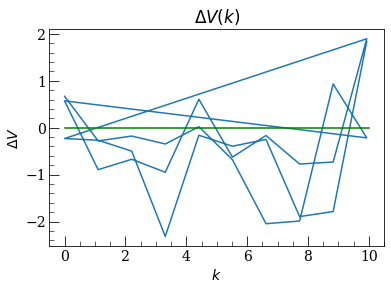

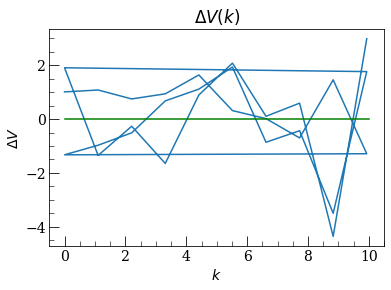

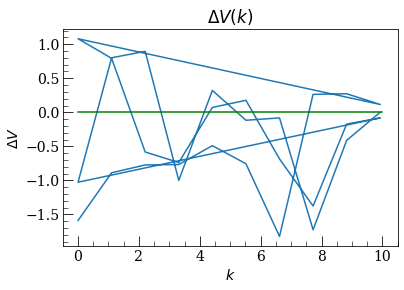

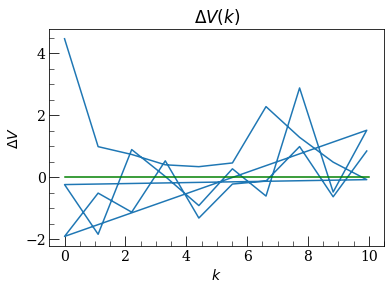

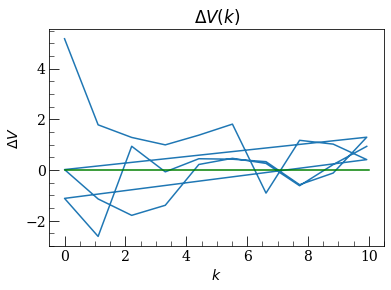

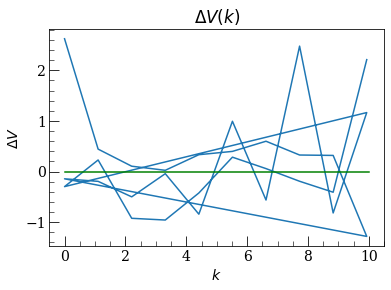

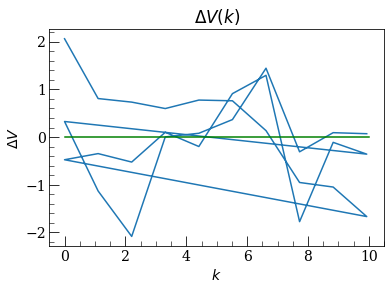

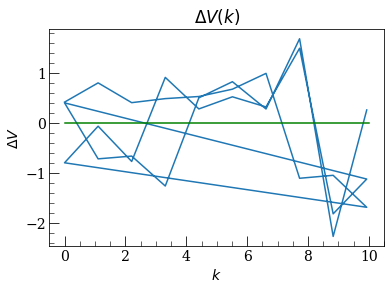

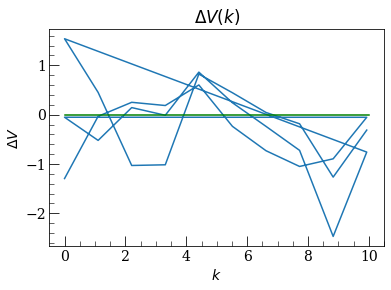

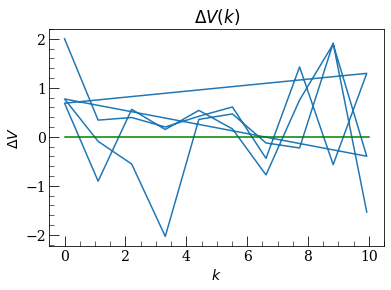

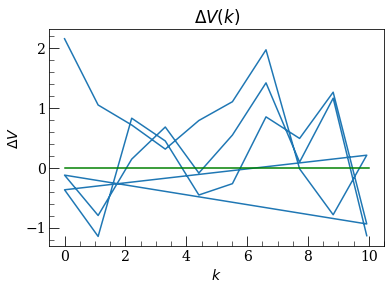

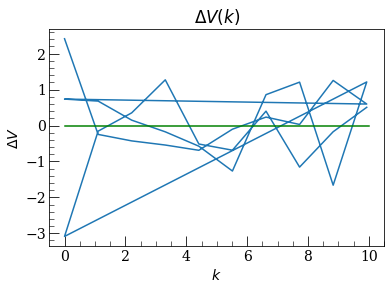

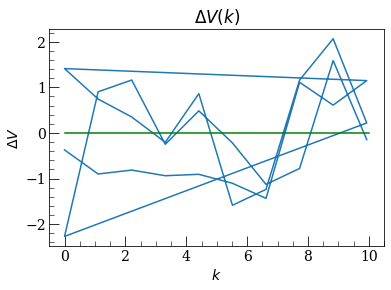

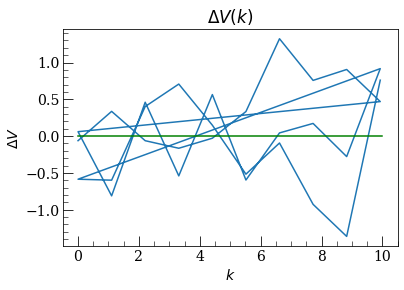

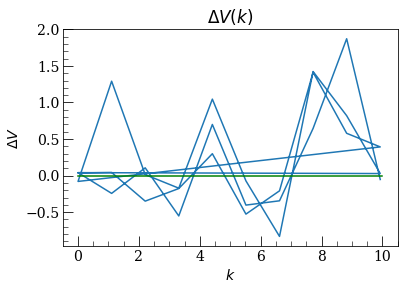

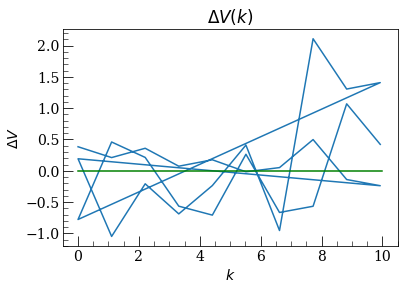

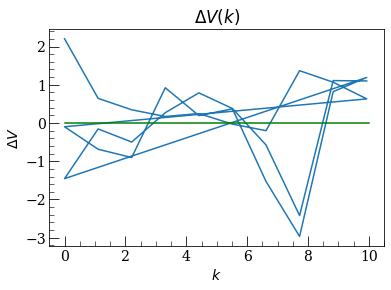

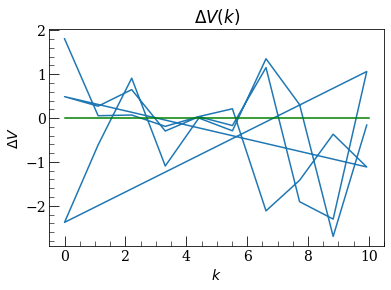

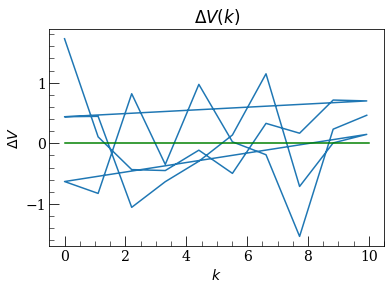

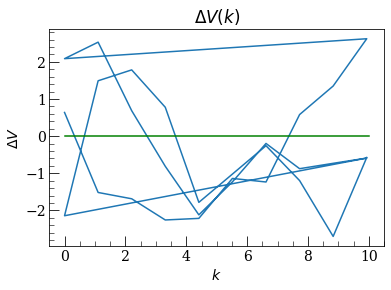

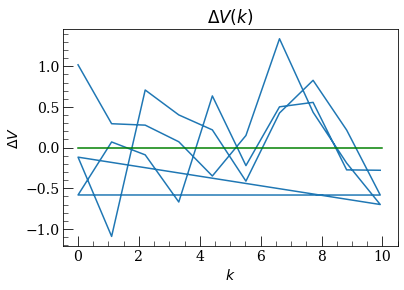

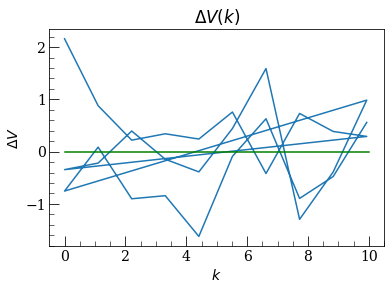

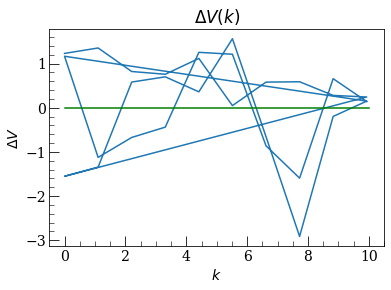

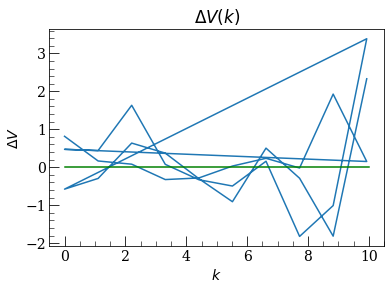

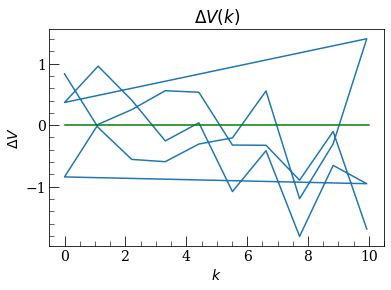

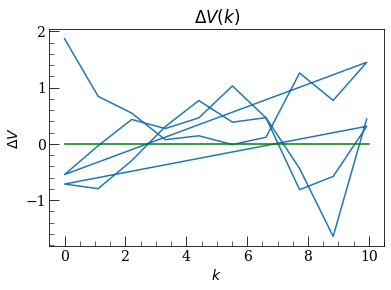

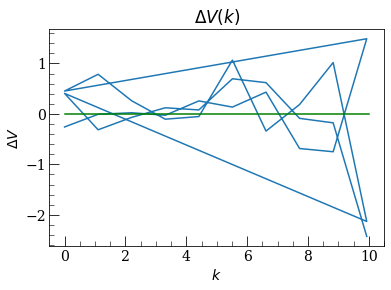

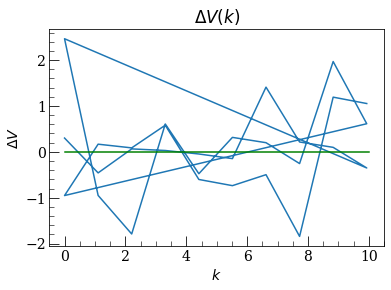

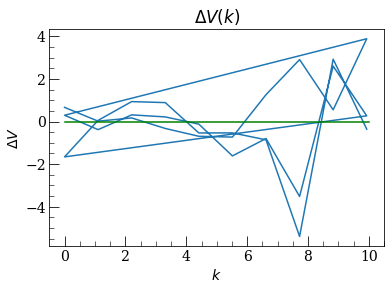

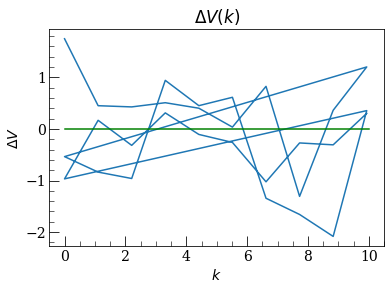

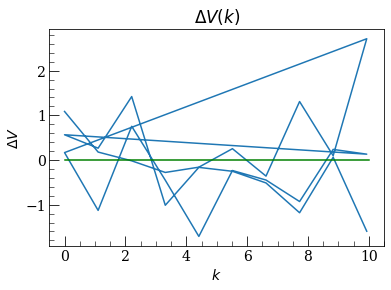

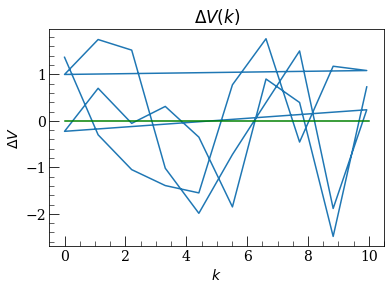

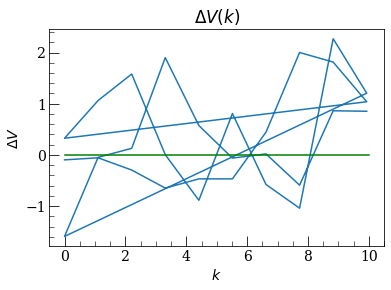

<Figure size 432x288 with 0 Axes>

In [353]:
# test model on data used to build model
V_test1 = np.zeros((c,c,thr_ct*3))
for i,o in enumerate(test_points[0]):
    for j,s in enumerate(test_points[1]):
        V_test1[i][j] = rgi((o,s))
        
print(V_test1.shape)

x = np.linspace(0,thr_ct,thr_ct)
y = np.zeros(len(x))
V = np.concatenate((v,v,v))

#delta_V = (V_clust - V_test)/np.std(V_clust,axis=0)
delta_V = (V_true - V_test1)/np.std(V_true,axis=0)
delta_V_plot = delta_V.reshape(c*c,thr_ct*3)

for t in range(c*c):
    plt.title((f'$\Delta V(k)$'))
    plt.plot(V,delta_V_plot[:][t])
    plt.plot(x,y,color='green')
    plt.xlabel('$k$')
    plt.ylabel('$\Delta V$')
    plt.figure();

In [323]:
'''V_true1 = np.zeros((c,thr_ct*3))

for i in range(c):
    V_true1[i] = V_true[i][i]
    
V_true1.shape
'''

(6, 30)

In [377]:
label[0]

array([0.2, 0.7])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

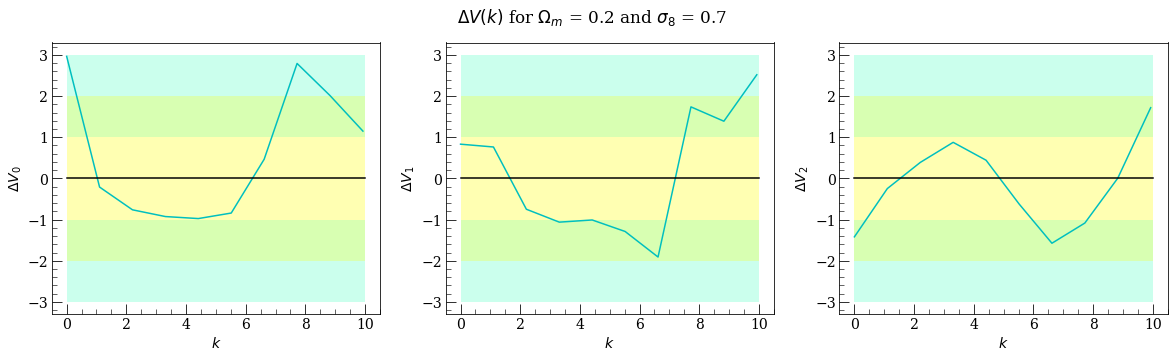

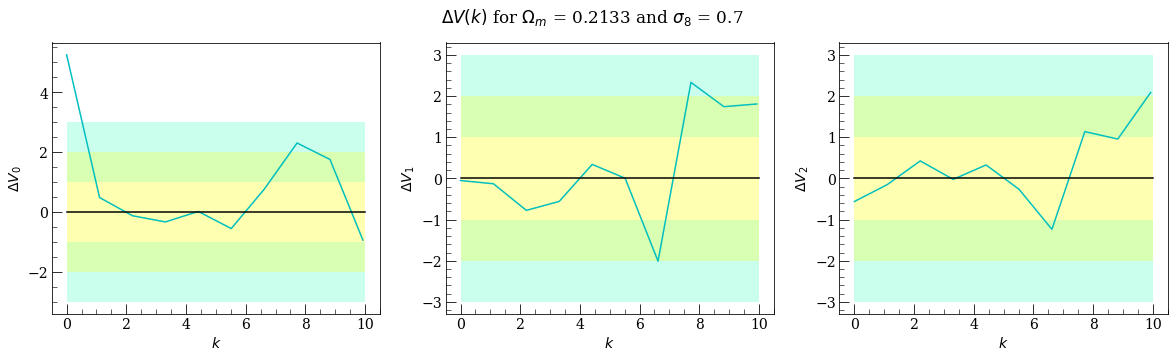

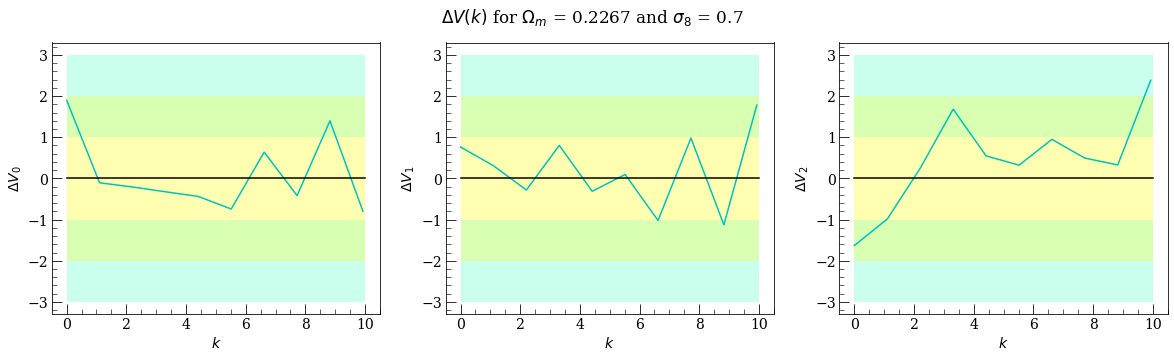

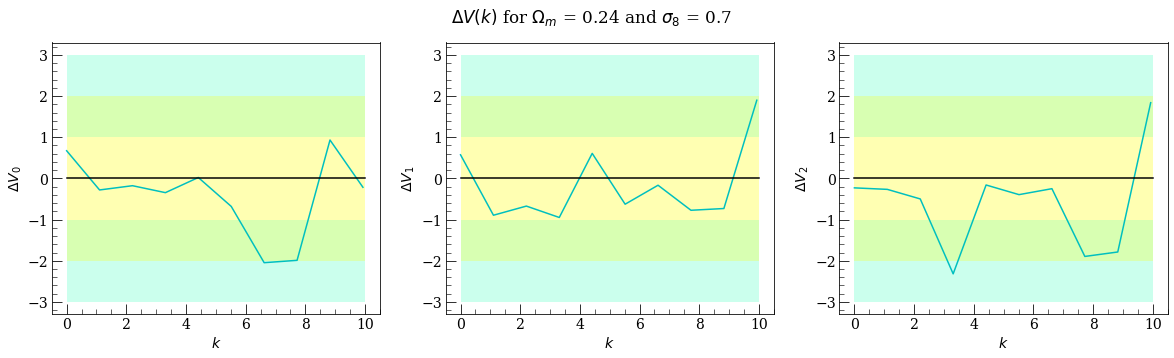

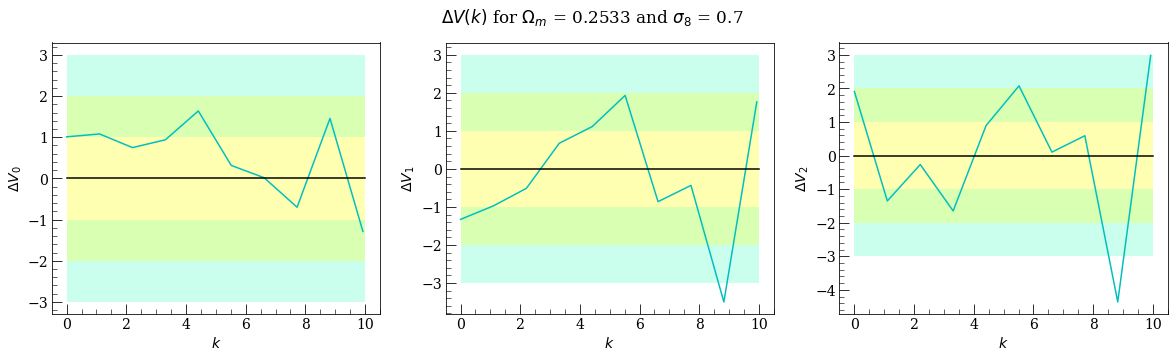

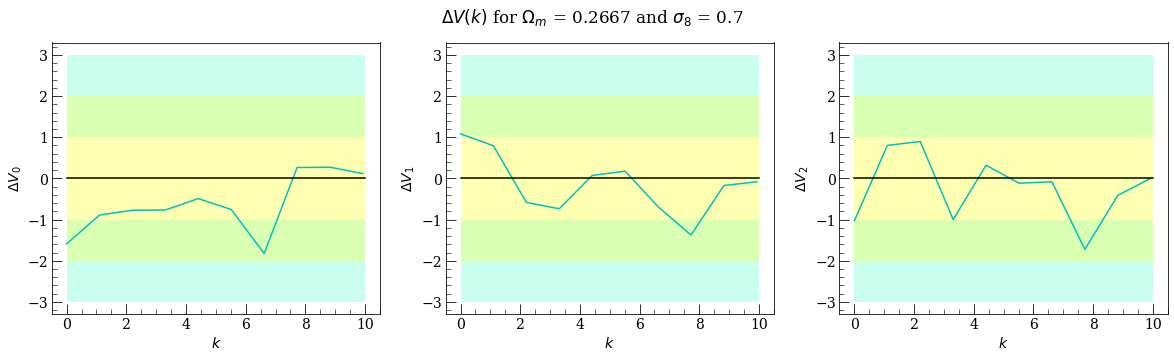

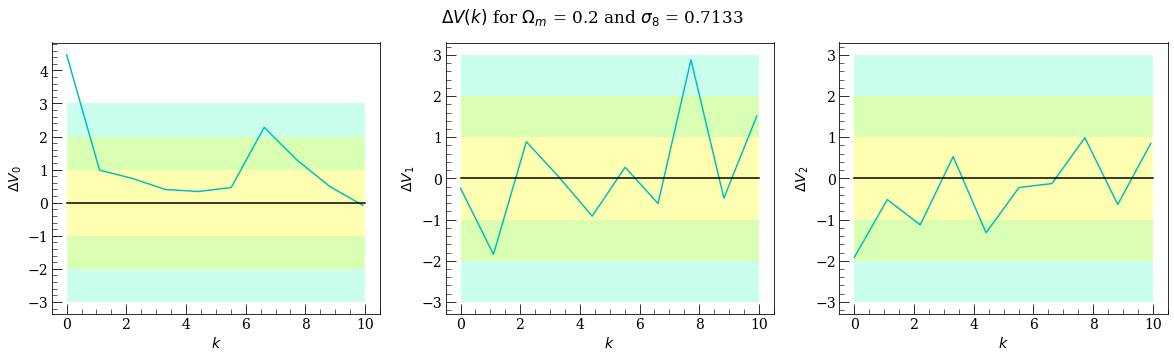

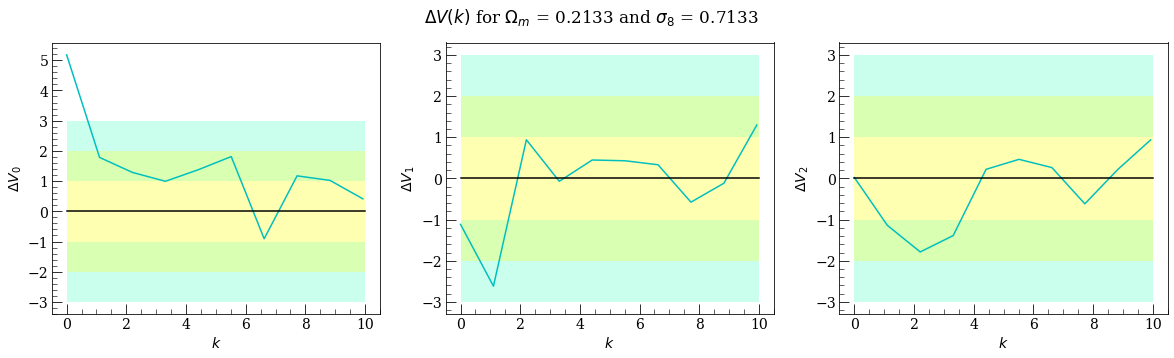

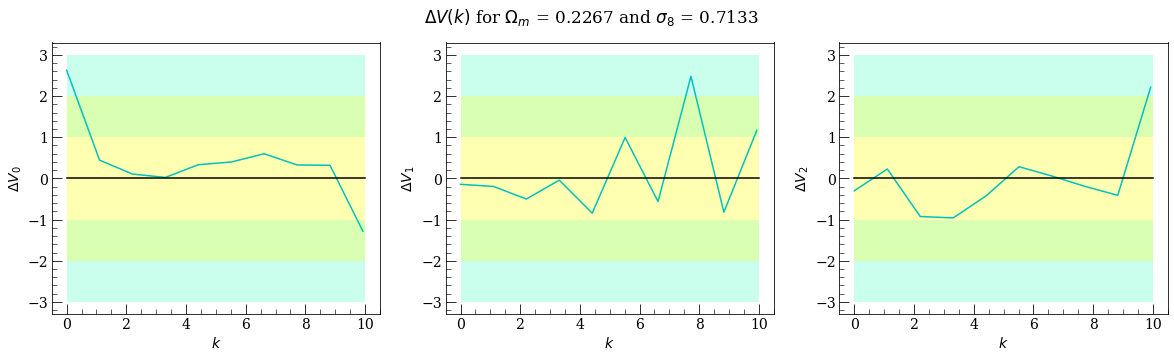

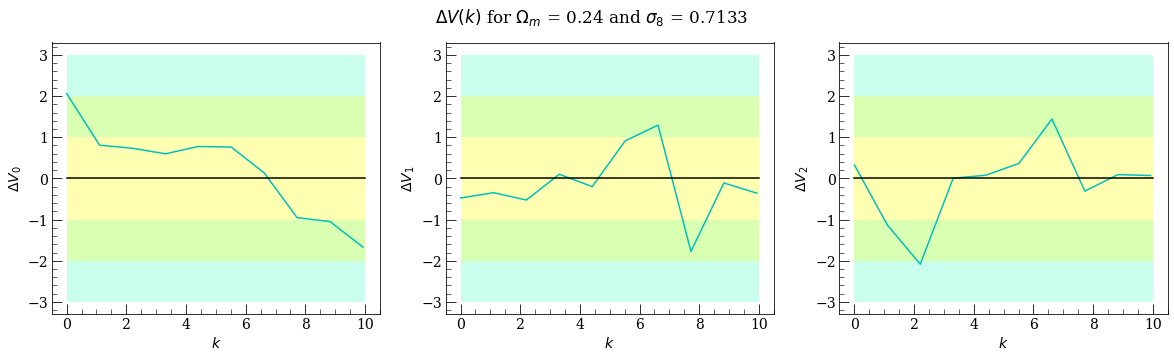

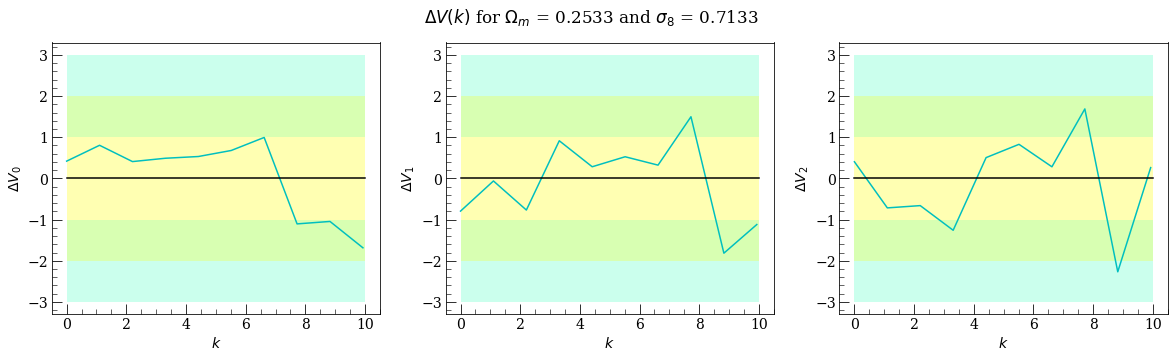

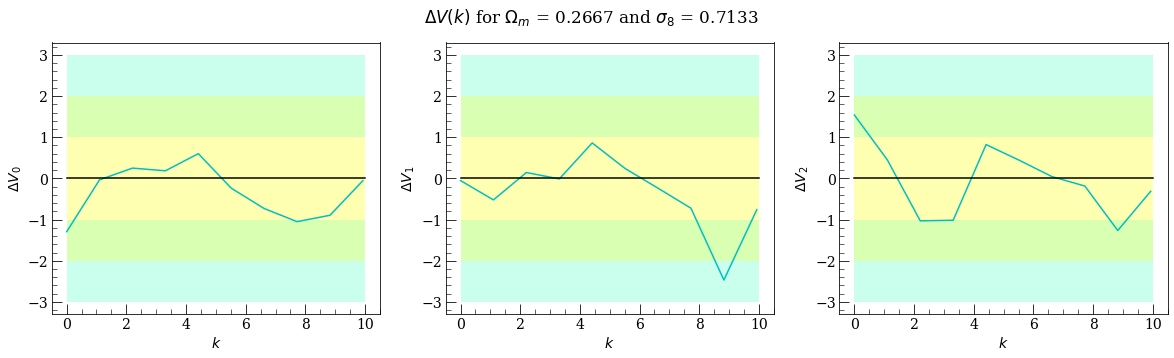

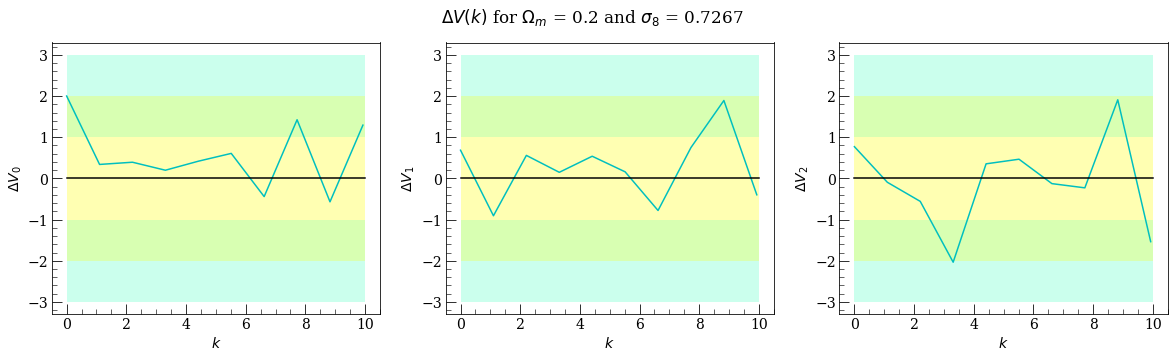

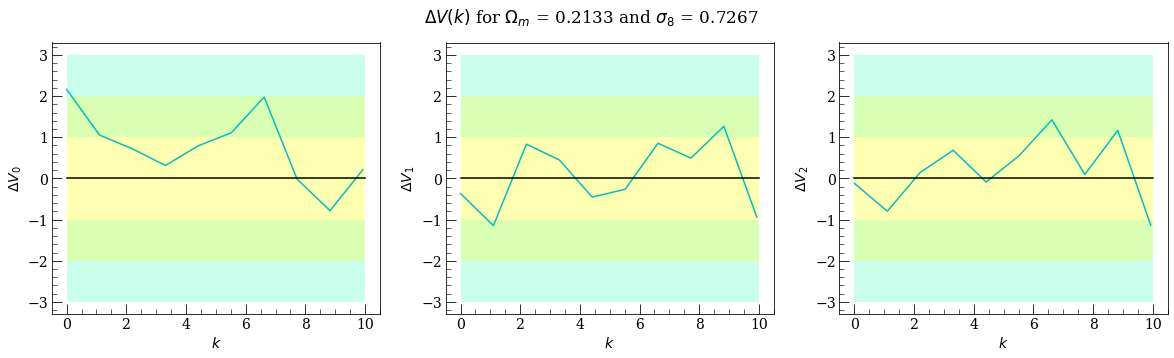

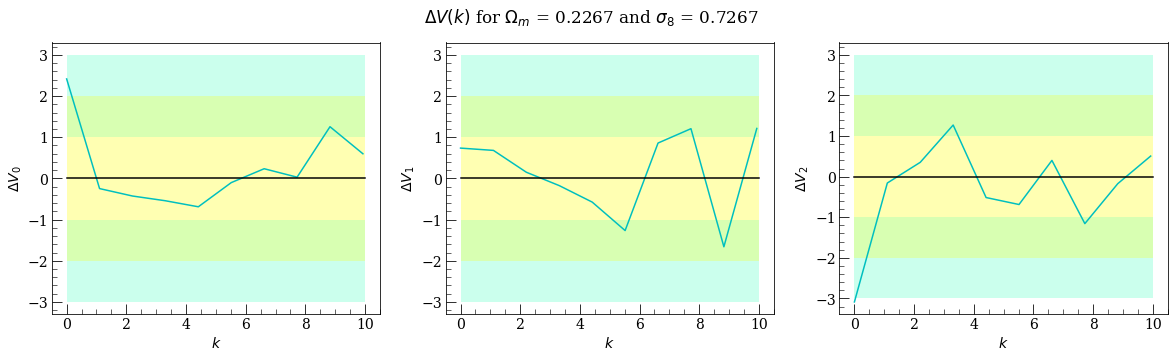

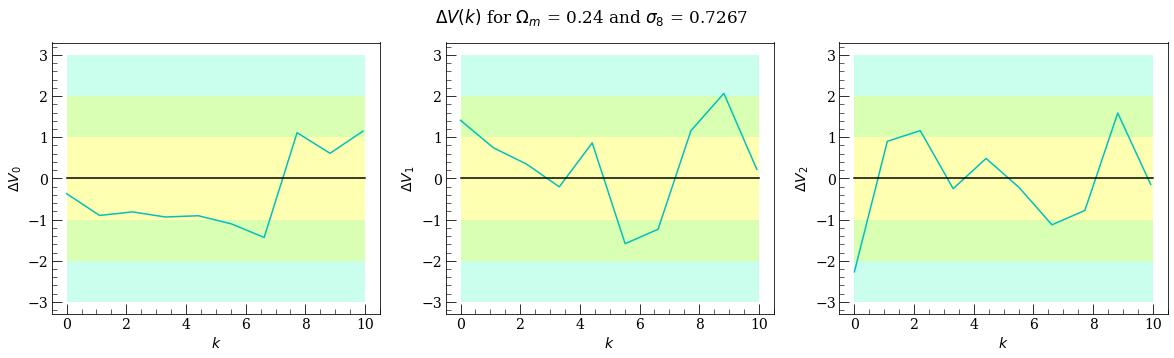

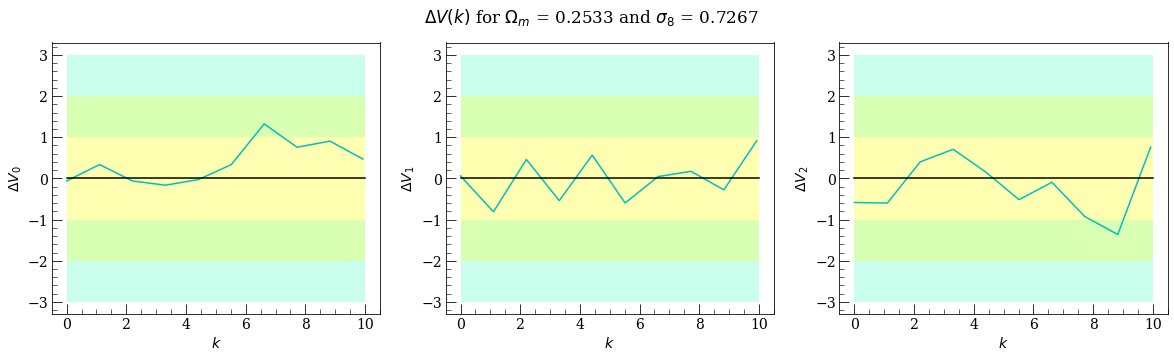

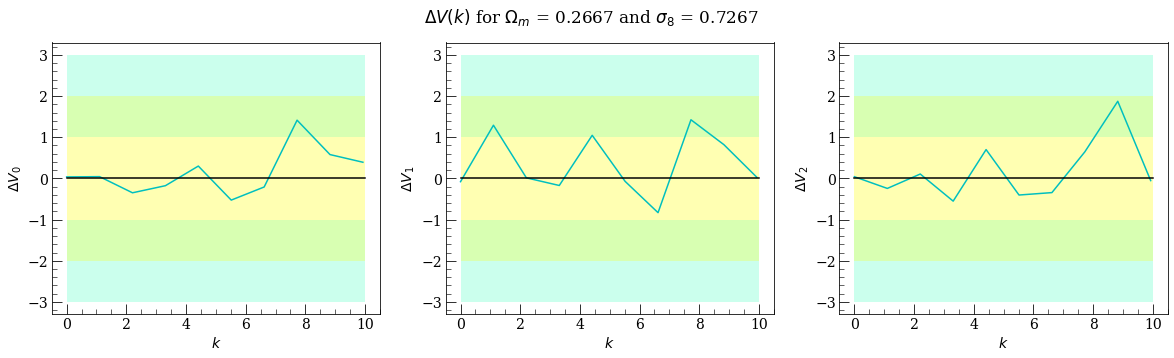

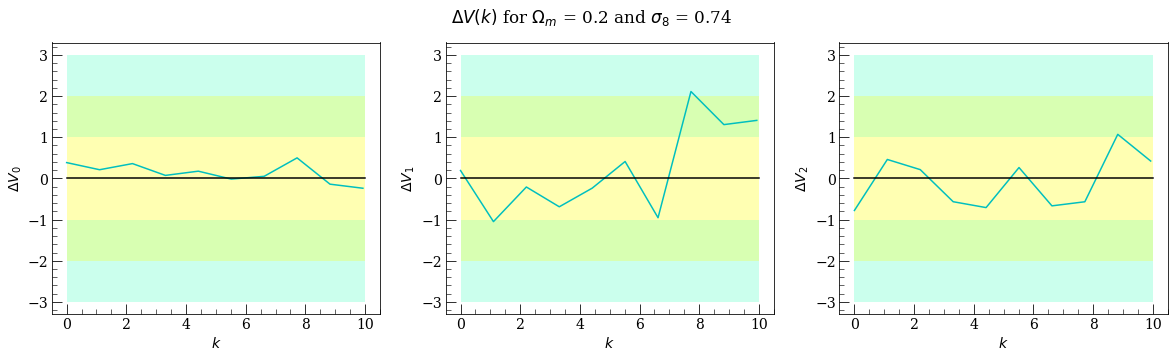

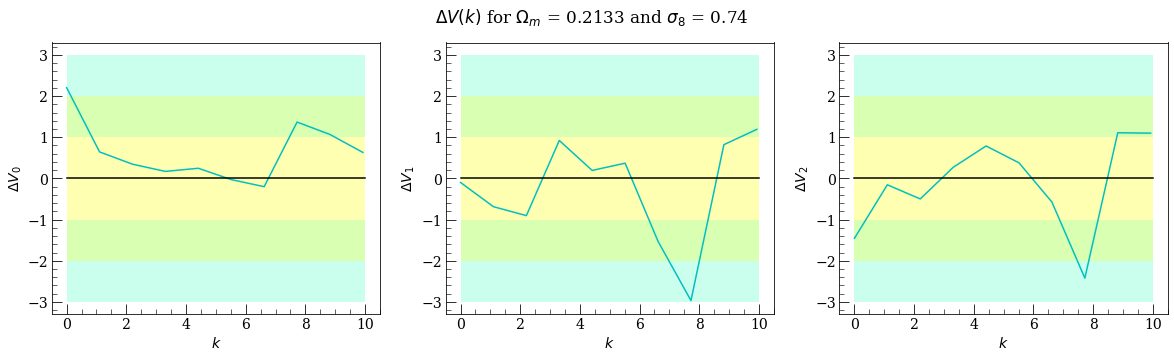

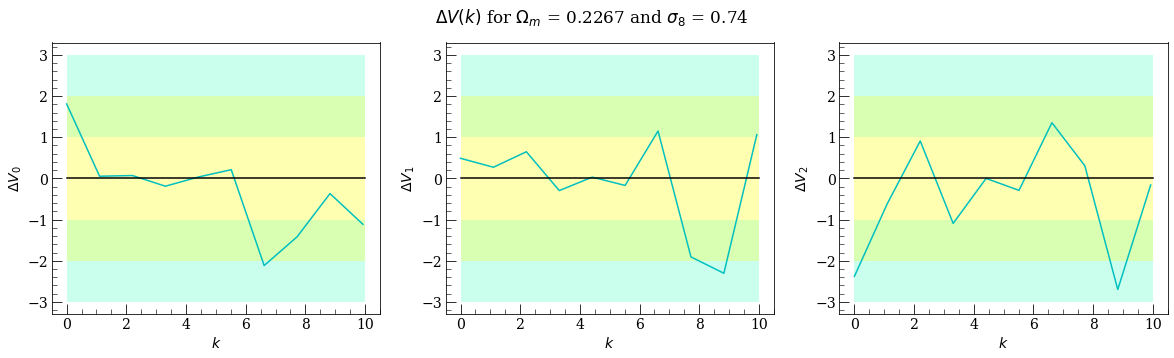

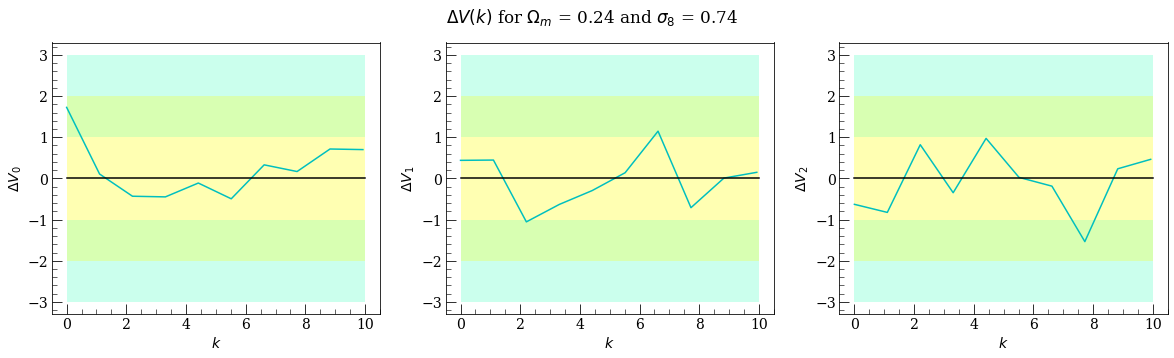

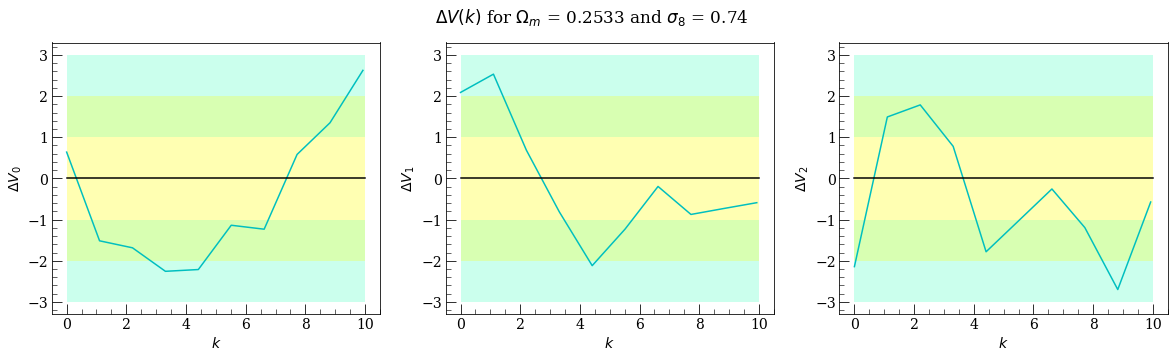

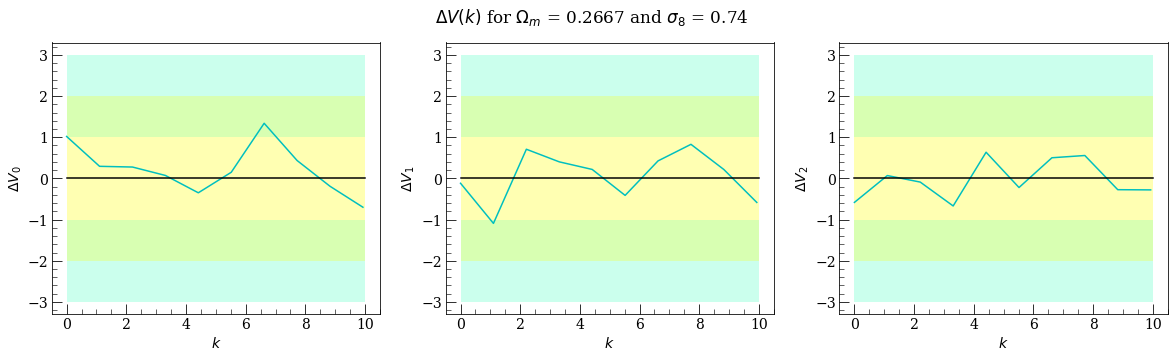

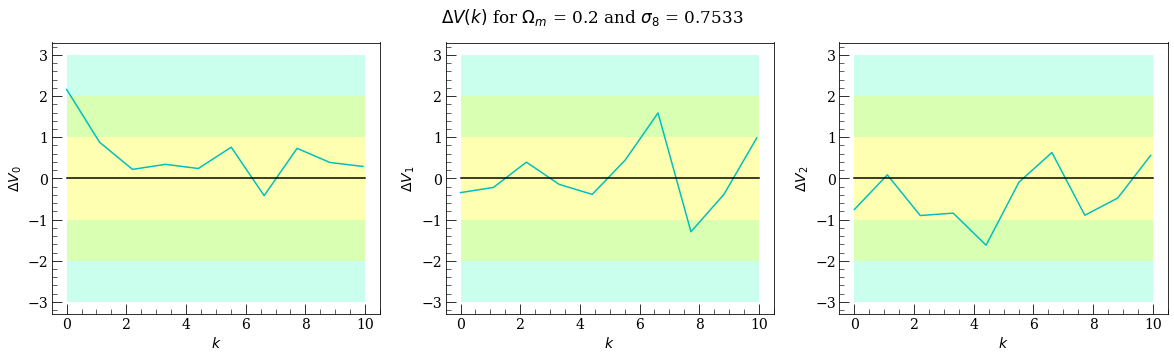

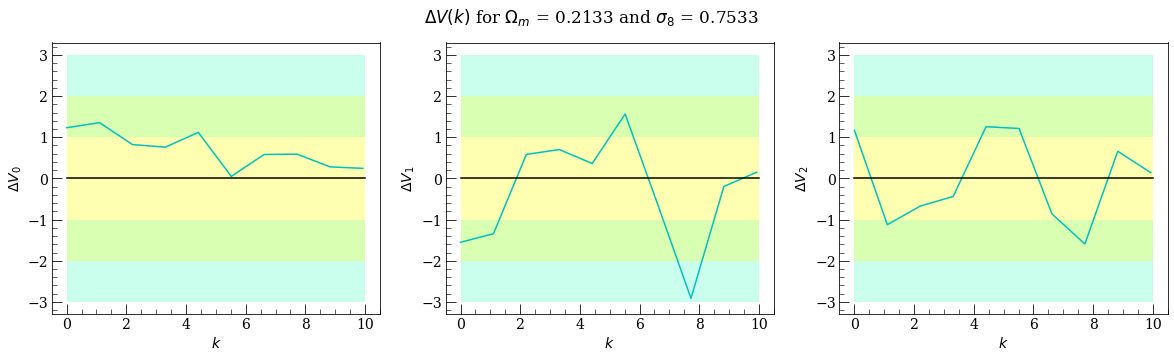

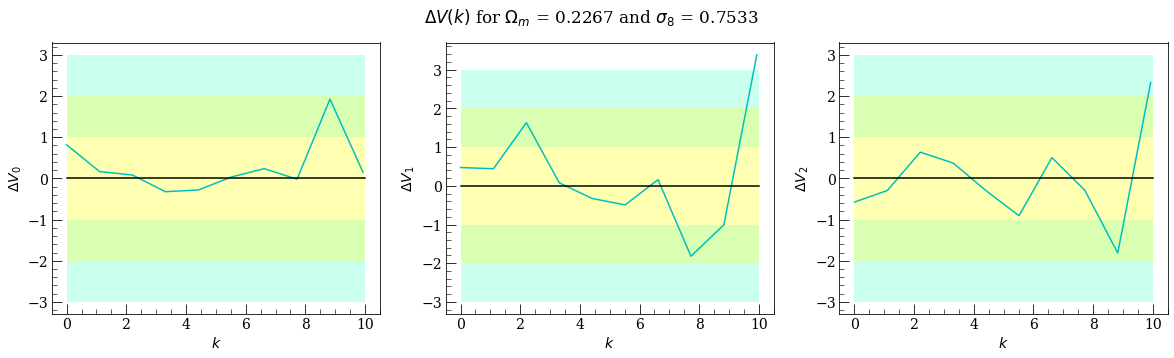

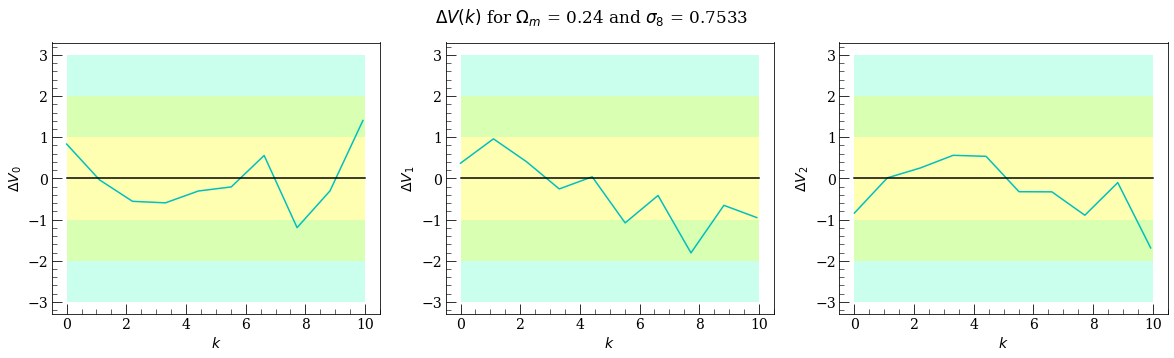

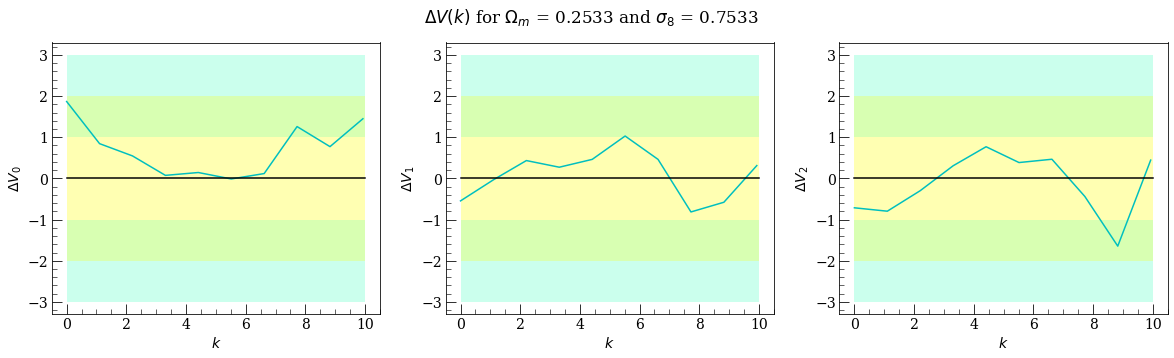

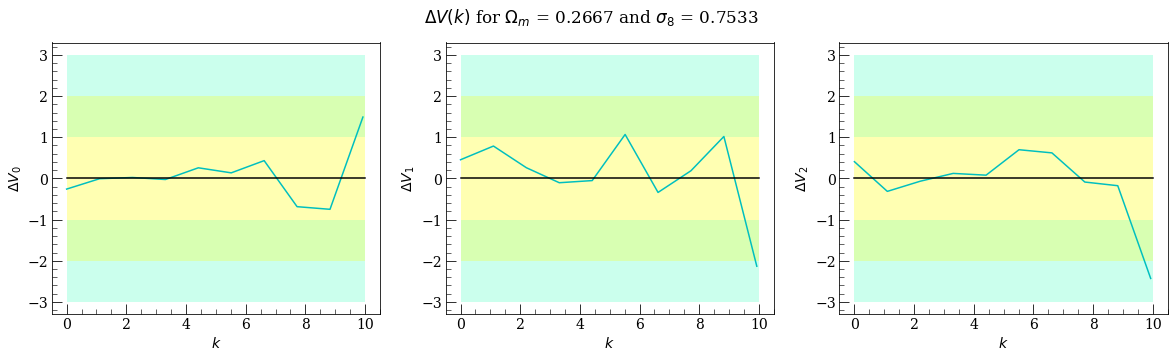

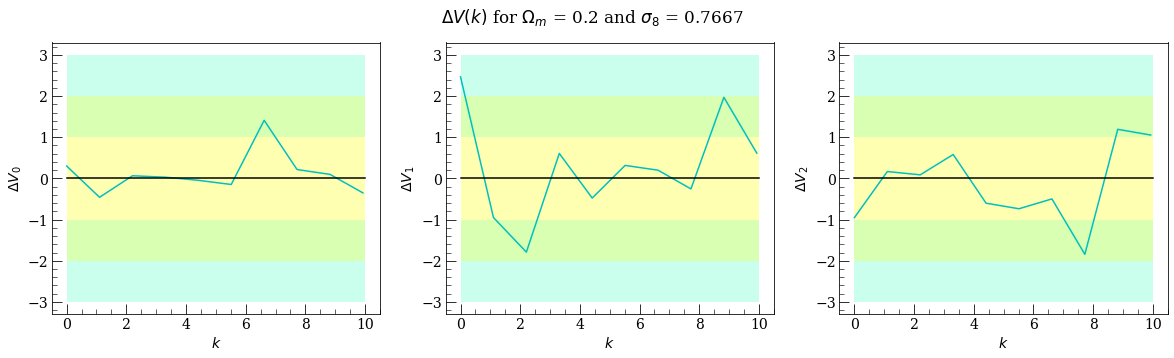

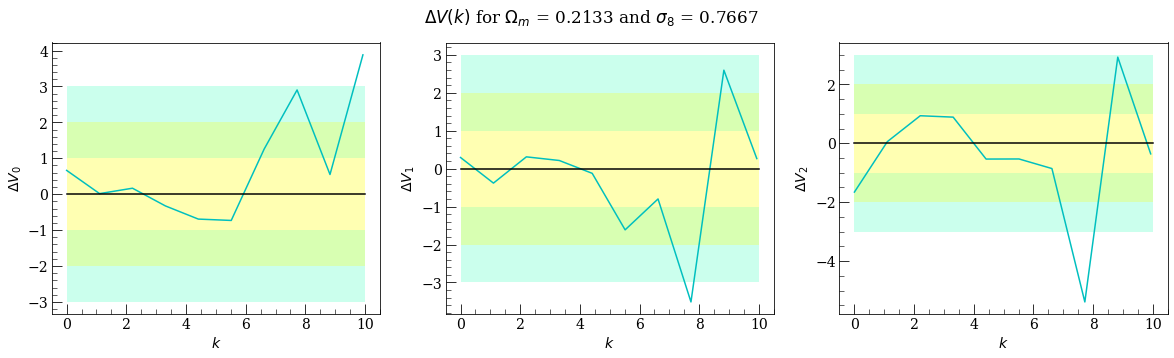

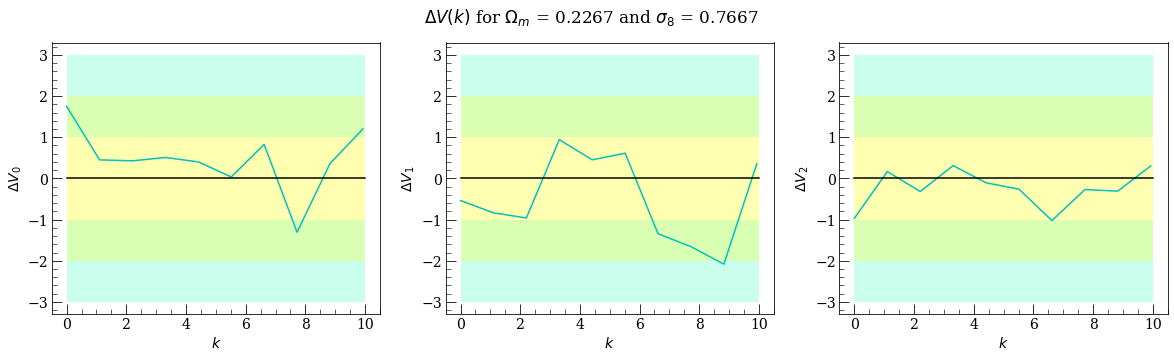

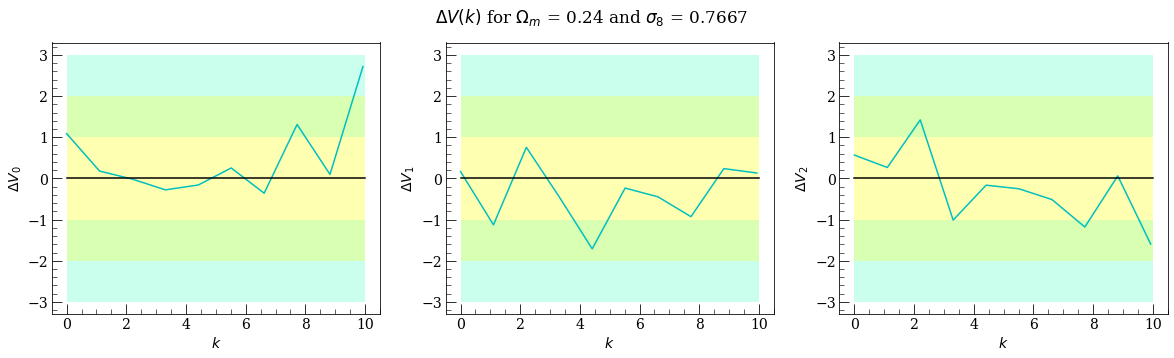

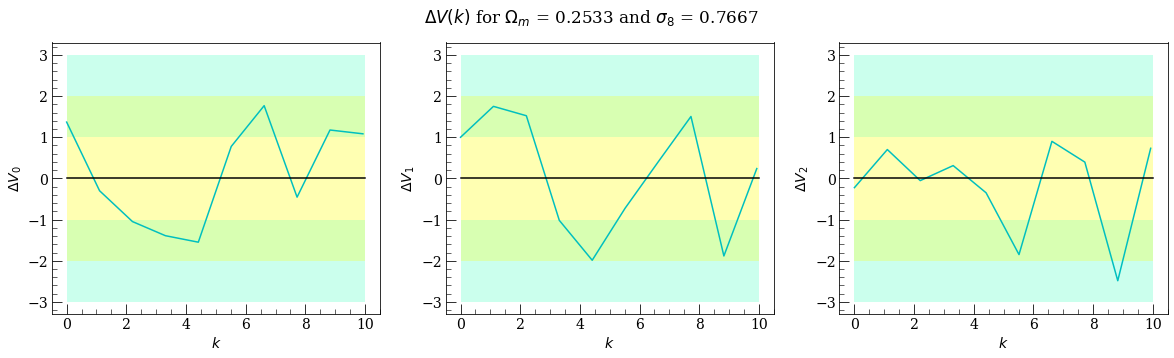

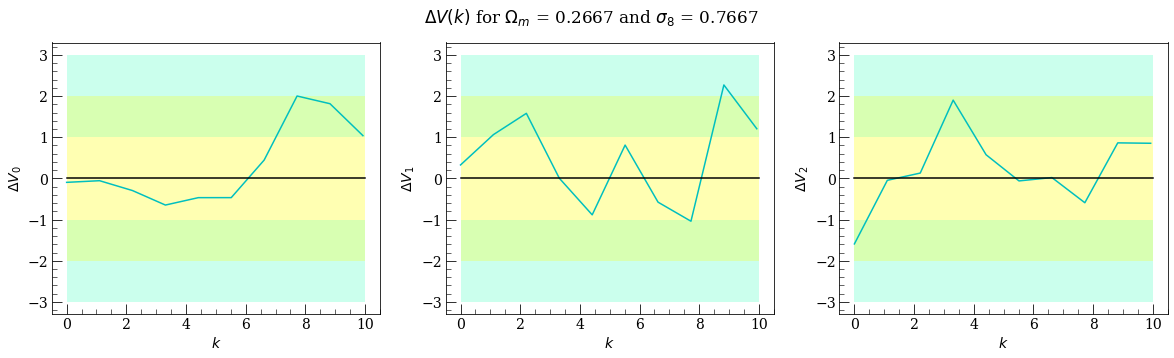

In [457]:
# compare model output to true values in an error plot 

max_v0 = np.zeros((c*c))
max_v1 = np.zeros((c*c))
max_v2 = np.zeros((c*c))

x = np.linspace(0,10,20)
y = np.zeros(len(x))

delta_V = ((V_true - V_test1)/np.std(V_true,axis=0)).reshape(c*c,30)
label = np.mgrid[os_grid[0][0]:os_grid[0][1]:c*1j,os_grid[1][0]:os_grid[1][1]:c*1j].transpose().reshape(c*c,2)

delta_V0_plot = delta_V[:,0:10]#.reshape(c*c,10)
delta_V1_plot = delta_V[:,10:20]#.reshape(c*c,10)
delta_V2_plot = delta_V[:,20:30]#.reshape(c*c,10)

y1 = y+1
y2 = y+2
y3 = y+3
y_1 = y-1
y_2 = y-2
y_3 = y-3

for t in range(c*c):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
    fig.suptitle(f'$\Delta V(k)$ for $\Omega_m$ = {round(label[t][0],4)} and $\sigma_8$ = {round(label[t][1],4)}')
    ax1.plot(v,delta_V0_plot[:][t],color='c')
    ax1.plot(x,y,color='black')
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$\Delta V_0$')
    ax1.fill_between(x, y, y1,facecolor="yellow",alpha=0.3) 
    ax1.fill_between(x, y_1, y,facecolor="yellow",alpha=0.3) 
    ax1.fill_between(x, y1, y2,facecolor="chartreuse",alpha=0.3) 
    ax1.fill_between(x, y_2, y_1,facecolor="chartreuse",alpha=0.3) 
    ax1.fill_between(x, y2, y3,facecolor="aquamarine",alpha=0.4) 
    ax1.fill_between(x, y_3, y_2,facecolor="aquamarine",alpha=0.4) 
    max_v0[t] = max(abs(delta_V0_plot[:][t]))
    ax2.plot(v,delta_V1_plot[:][t],color='c')
    ax2.plot(x,y,color='black')
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$\Delta V_1$')
    ax2.fill_between(x, y, y1,facecolor="yellow",alpha=0.3) 
    ax2.fill_between(x, y_1, y,facecolor="yellow",alpha=0.3) 
    ax2.fill_between(x, y1, y2,facecolor="chartreuse",alpha=0.3) 
    ax2.fill_between(x, y_2, y_1,facecolor="chartreuse",alpha=0.3) 
    ax2.fill_between(x, y2, y3,facecolor="aquamarine",alpha=0.4) 
    ax2.fill_between(x, y_3, y_2,facecolor="aquamarine",alpha=0.4) 
    max_v1[t] = max(abs(delta_V1_plot[:][t]))
    ax3.plot(v,delta_V2_plot[:][t],color='c')
    ax3.plot(x,y,color='black')
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$\Delta V_2$')
    ax3.fill_between(x, y, y1,facecolor="yellow",alpha=0.3) 
    ax3.fill_between(x, y_1, y,facecolor="yellow",alpha=0.3) 
    ax3.fill_between(x, y1, y2,facecolor="chartreuse",alpha=0.3) 
    ax3.fill_between(x, y_2, y_1,facecolor="chartreuse",alpha=0.3) 
    ax3.fill_between(x, y2, y3,facecolor="aquamarine",alpha=0.4) 
    ax3.fill_between(x, y_3, y_2,facecolor="aquamarine",alpha=0.4) 
    max_v2[t] = max(abs(delta_V2_plot[:][t]))

In [415]:
max_v1

array([2.51677194, 2.33111514, 1.7778992 , 1.89816992, 3.49943696,
       1.37684724, 2.88089698, 2.61644896, 2.47933619, 1.77330186,
       1.81598738, 2.46743359, 1.89154935, 1.26575387, 1.66032304,
       2.06448734, 0.91691611, 1.423639  , 2.10989459, 2.96678384,
       2.30334922, 1.14673181, 2.53140671, 1.09242656, 1.58908198,
       2.91278698, 3.38321471, 1.80910206, 1.02890583, 2.13267534,
       2.46508644, 3.51400797, 2.08287517, 1.71010996, 1.98740736,
       2.26906624])

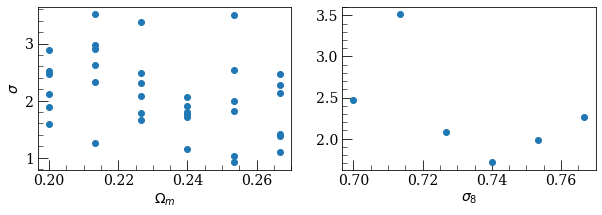

In [456]:
nisha = 5
n = nisha*6
g = n+6

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
#ax1.plot(label[n:g][:,0],max_v1[n:g],'o')
ax1.plot(label[:,0],max_v1,'o')
ax1.set_xlabel('$\Omega_m$')
ax1.set_ylabel('$\sigma$')
ax2.plot(test_points[1],max_v1[n:g],'o')
ax2.set_xlabel('$\sigma_8$');
#ax2.set_ylabel('$\sigma$');

In [ ]:
# calculate MFs for the grid -> put output in a new grid
'''
V_clust = np.zeros((a,a,thr_ct*3))
os_grid = np.vstack((omega[:,0],sigma[0]))

for i,o in enumerate(omega[:,0]):
    for j,s in enumerate(sigma[0]):
        c_map, l_map = simulate_des_maps(o, s, smoothing, nside, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        V_clust[i][j] = np.concatenate((v0,v1,v2))
        
# build interpolator
rgi = RegularGridInterpolator(os_grid, V_clust, method='linear', bounds_error=True, fill_value=nan)

'''

In [ ]:
'''
# compare model output to true values in an error plot 

x = np.linspace(0,10,10)
y = np.zeros(len(x))

delta_V = (V_true1 - V_test1)/np.std(V_true1,axis=0)

delta_V0_plot = delta_V[:,:,0:10].reshape(c*c,10)
delta_V1_plot = delta_V[:,:,10:20].reshape(c*c,10)
delta_V2_plot = delta_V[:,:,20:30].reshape(c*c,10)

for t in range(c):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
    fig.suptitle(f'$\Delta V(k)$ for $\Omega_m$ = {round(test[0][t],4)} and $\sigma_8$ = {round(test[1][t],4)}')
    ax1.plot(v,delta_V0_plot[:][t])
    ax1.plot(x,y,color='green')
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$\Delta V$')
    ax2.plot(v,delta_V1_plot[:][t])
    ax2.plot(x,y,color='green')
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$\Delta V$')
    ax3.plot(v,delta_V2_plot[:][t])
    ax3.plot(x,y,color='green')
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$\Delta V$')
'''

In [292]:
# make a grid of in between grid points  - can't exceed current points

test = np.copy(os_grid)
for i in range(2):
    for j in range(a):
        if j<(a-1):
            test[i][j] = test[i][j] + np.random.random(1)*.001
        else:
            test[i][j] = test[i][j] - np.random.random(1)*.001
print(test)

[[0.200228   0.26677233 0.33351219 0.39990522]
 [0.70044434 0.76729585 0.8339348  0.89989819]]
